<a href="https://colab.research.google.com/github/skosch/YinYangFit/blob/master/YinYangFit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up TF2 and import dependencies

In [1]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf
import os

print("TF version:", tf.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

if tf.test.is_gpu_available():
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
      raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
else:
    tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
    
    cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(cluster_resolver)
    tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
    tpu_strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)


TensorFlow 2.x selected.
TF version: 2.1.0-rc1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available
Found GPU at: /device:GPU:0


In [2]:
import itertools
import os

import numpy as np
pi = np.pi

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.ndimage.interpolation import affine_transform
import tensorflow as tf
import random; random.seed()
import math
import pickle
import os
from tqdm import tqdm as tqdm
import sys
from functools import reduce
import random
from itertools import cycle, islice, product
import operator

!pip install --quiet --upgrade git+git://github.com/simoncozens/tensorfont.git
!pip install --quiet fonttools
!pip install --upgrade git+git://github.com/simoncozens/fontParts.git@d444bde6e2a0adbcd9a16593a615a99823089c70
!pip install booleanOperations
!pip install --quiet --upgrade ufo-extractor
!pip install --quiet --upgrade defcon
!pip install --quiet --upgrade ufo2ft
import fontParts
import extractor
import defcon
from ufo2ft import compileOTF

from tensorfont import Font

print("✓ Dependencies imported.")



     |████████████████████████████████| 890kB 2.6MB/s 
     |████████████████████████████████| 727kB 2.8MB/s 
  Cloning git://github.com/simoncozens/fontParts.git (to revision d444bde6e2a0adbcd9a16593a615a99823089c70) to /tmp/pip-req-build-375lnjzp
  Running command git clone -q git://github.com/simoncozens/fontParts.git /tmp/pip-req-build-375lnjzp
  Running command git checkout -q d444bde6e2a0adbcd9a16593a615a99823089c70
     |████████████████████████████████| 194kB 4.1MB/s 
     |████████████████████████████████| 133kB 13.9MB/s 
     |████████████████████████████████| 419kB 9.4MB/s 
  Created wheel for fontParts: filename=fontParts-0.9.1.dev0-cp36-none-any.whl size=175280 sha256=d0e9f834ca525d83796ed2d8730d7c6e913f47440753c41ac9f675fc06fb6dc5
  Stored in directory: /tmp/pip-ephem-wheel-cache-xffchbof/wheels/f8/18/00/555dac1d1bf8d03d0ec038547c75789c8a1019ea39daed538c
Successfully built fontParts
     |████████████████████████████████| 133kB 4.2MB/s 
     |█████████████████████████████

### Download font files

In [3]:
#!wget -q -O OpenSans-Regular.ttf https://github.com/googlefonts/opensans/blob/master/ttfs/OpenSans-Regular.ttf?raw=true
#!wget -q -O Roboto.ttf https://github.com/google/fonts/blob/master/apache/roboto/Roboto-Regular.ttf?raw=true
#!wget -q -O Roboto.otf https://github.com/AllThingsSmitty/fonts/blob/master/Roboto/Roboto-Regular/Roboto-Regular.otf?raw=true
#!wget -q -O DroidSerif.ttf https://github.com/datactivist/sudweb/blob/master/fonts/droid-serif-v6-latin-regular.ttf?raw=true
!wget -q -O CrimsonItalic.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Italic.otf?raw=true
#!wget -q -O CrimsonBold.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Bold.otf?raw=true 
#!wget -q -O CrimsonRoman.otf https://github.com/alif-type/amiri/blob/master/Amiri-Regular.ttf?raw=true

!wget -q -O CrimsonRoman.otf https://github.com/skosch/Crimson/blob/master/Desktop%20Fonts/OTF/Crimson-Roman.otf?raw=true
print("✓ Font file(s) downloaded.")

✓ Font file(s) downloaded.


## Load font data and set up global parameters

In [4]:
glyph_char_list = "abcdeghijlmnopqrstuzywvxkf"
#glyph_char_list = "abgjqrst"
#glyph_char_list = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
#glyph_char_list = "OO"

# ==== Create Font ====
factor = 1.14 #1.539  # This scales the size of everything
filename = "CrimsonRoman.otf"
f = Font(filename, 34 * factor) # Roboto.ttf CrimsonRoman.otf # 34 for lowercase
box_height = f.full_height_px
box_width = int(121 * factor)
box_width += (box_width + 1) % 2
print("Box size:", box_height, "×", box_width)

# 37067520 allocated, maxAllocSize: 873707520

batch_size = 1  # must be divisible by 8 to work on TPU
n_sample_distances = 3 # should be an odd number

n_sizes = 18
n_pseudo_orientations = 4
n_orientations = 4

Box size: 91 × 137


## Create Gabor filter bank

In [5]:
def get_sigmas(skip_scales=0):
    sigmas = []
    for s in range(n_sizes):
        min_sigma = 0.6
        max_sigma = box_width / 12
        #sigmas.append((max_sigma - min_sigma) * (s + skip_scales)**2 / (n_sizes - 1)**2 + min_sigma)
        sigmas.append((max_sigma - min_sigma) * s / n_sizes + min_sigma)
    return np.array(sigmas)
print("Sigmas are", get_sigmas())

def get_3n_filters(skip_scales, display_filters=False):
    def rotated_mgrid(oi):
        """Generate a meshgrid and rotate it by RotRad radians."""
        rotation = np.array([[ np.cos(pi*oi/n_orientations), np.sin(pi*oi/n_orientations)],
                             [-np.sin(pi*oi/n_orientations), np.cos(pi*oi/n_orientations)]])
        hh = box_height # / 2
        bw = box_width # / 2
        y, x = np.mgrid[-hh:hh, -bw:bw].astype(np.float32)
        y += 0.5 # 0 if box_height % 2 == 0 else 0.5
        x += 0.5 # 0 if box_width % 2 == 0 else 0.5
        return np.einsum('ji, mni -> jmn', rotation, np.dstack([x, y]))

    def get_filter(sigma, theta):
        x, y = rotated_mgrid(theta)

        # To minimize ringing etc., we create the filter as is, then run it through the DFT.
        a1 = 0.25 # See Georgeson et al. 2007
        s1 = sigma #a1 * sigma
        d1_space = -np.exp(-(x**2+y**2)/(2*s1**2))*x/(2*pi*s1**4)
        d1 = np.fft.fft2(d1_space + 1j * np.zeros_like(d1_space)) #, [box_height, box_width])

        # Second derivative:
        s2 = sigma #np.sqrt(1. - a1**2) * sigma # See Georgeson et al. (2007)
        d2_space = np.exp(-(x**2+y**2)/(2*s2**2))/(2*pi*s2**4) - np.exp(-(x**2+y**2)/(2*s2**2))*x**2/(2*pi*s2**6)
        d2 = sigma**1.5 * np.fft.fft2(d2_space + 1j * np.zeros_like(d2_space)) #, [box_height, box_width])

        # For now: d1 is complex(-d2,d1)
        d1c = 1j * (d2 + 1j*d1) #/ sigma #np.sqrt(sigma)
        return (d1c, d2)

    d1_bank = np.zeros((n_sizes, n_orientations, 2*box_height, 2*box_width)).astype(np.complex64)
    d2_bank = np.zeros((n_sizes, n_orientations, 2*box_height, 2*box_width)).astype(np.complex64)

    if display_filters:
        sizediv = 60
        fig, ax = plt.subplots(nrows=n_sizes*2, ncols=n_orientations, gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(box_width * n_orientations / sizediv, box_height * n_sizes * 2 / sizediv))

    sigmas = get_sigmas()
    for s in range(n_sizes):
        sigma = sigmas[s]
        for o in range(n_orientations):
            (d1, d2) = get_filter(sigma, o)
            if display_filters:
                #ax[s*2, o].imshow(np.real(np.fft.ifft2(d1)), cmap="inferno")
                ax[s*2, o].imshow(np.abs(np.fft.fftshift(d1)), cmap="inferno")
                ax[s*2, o].set_aspect("auto")
                ax[s*2, o].set_yticklabels([])
                ax[s*2+1, o].imshow(np.imag(np.fft.ifft2(d1)), cmap="inferno")
                ax[s*2+1, o].set_aspect("auto")
                ax[s*2+1, o].set_yticklabels([])
            d1_bank[s, o, :, :] = d1
            d2_bank[s, o, :, :] = d2

    if display_filters:
        plt.show()

    return (d1_bank.astype(np.complex64), d2_bank)

d1_filter_bank, d2_filter_bank = get_3n_filters(0, False)

Sigmas are [ 0.6         1.20092593  1.80185185  2.40277778  3.0037037   3.60462963
  4.20555556  4.80648148  5.40740741  6.00833333  6.60925926  7.21018519
  7.81111111  8.41203704  9.01296296  9.61388889 10.21481481 10.81574074]


## Rasterize the glyphs into numpy arrays, and extract their ink widths in pixels


In [0]:
def apply_filter_bank(input_image, filter_bank):
    """
    Input image should have dimensions <h, w> or <s, o, h, w> or <b, s, o, h, w, d>.
    Filter bank should have dimensions <s, o, h, w>
    """
    if len(input_image.shape) == 2:
        bdsohw_input_image = input_image[None, None, None, None, :, :]
    elif len(input_image.shape) == 4:
        bdsohw_input_image = input_image[None, None, :, :, :, :]
    elif len(input_image.shape) == 6:
        bdsohw_input_image = tf.einsum("bsohwd->bdsohw", input_image)

    # pad image to filter size, which is 2*box_height, 2*box_width (to prevent too much wrapping)
    padded_input = tf.pad(bdsohw_input_image, [[0, 0], [0, 0], [0, 0], [0, 0],
                            [int(np.ceil(box_height / 2)), int(box_height / 2)],
                            [int(np.ceil(box_width / 2)), int(box_width / 2)]], mode='CONSTANT')

    input_in_freqdomain = tf.signal.fft2d(tf.dtypes.cast(tf.complex(padded_input, tf.zeros_like(padded_input)), tf.complex64))

    padded_result = (tf.signal.ifft2d(input_in_freqdomain * filter_bank[None, None, :, :, :, :]))

    if len(input_image.shape) == 2:
        presult = tf.signal.fftshift(padded_result[0, 0, :, :, :, :], axes=[2, 3])
        # Return <s, o, h, w>
        return (presult[:, :, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                           int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))],
                input_in_freqdomain)
    elif len(input_image.shape) == 4:
        presult = tf.signal.fftshift(padded_result[0, 0, :, :, :, :], axes=[2, 3])
        # Return <s, o, h, w>
        return (presult[:, :, int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                           int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))],
                input_in_freqdomain)
    elif len(input_image.shape) == 6:
        presult = tf.einsum("bdsohw->bsohwd", tf.signal.fftshift(padded_result, axes=[2, 3]))
        return (presult[:, :, :, :,
                           int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                           int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))],
                input_in_freqdomain)

def get_glyph_data_with_filtered_as_dict(glyph_char):
    """
    Returns a dict containing relevant glyph data, including filtered images.
    @param glyph_char: string of length 1
    """
    glyph_image = f.glyph(glyph_char).as_matrix(normalize=True).with_padding_to_constant_box_width(box_width).astype(np.float32)
    filtered_image, fft_image = apply_filter_bank(glyph_image, d1_filter_bank)

    return {
        'glyph_char': glyph_char,
        'glyph_image': glyph_image,
        'glyph_ink_width': f.glyph(glyph_char).ink_width,
        'glyph_d1_filtered_images': filtered_image,
        'glyph_fft_image': fft_image,
    }

def get_sample_distances_and_translations(gd1, gd2, target_ink_distance, distances=None):
    """Returns a list of distances at which the box images have to be shifted left and right before they can be overlaid to sample their normalized interaction"""
    total_width_at_minimum_ink_distance = gd1['glyph_ink_width'] + gd2['glyph_ink_width'] - f.minimum_ink_distance(gd1['glyph_char'], gd2['glyph_char'])
    
    if distances is None:
        relative_sample_distances = [0]
        simax = int((n_sample_distances - 1)/2)
        
        pos_ad = +3 #/ 2.
        neg_ad = -3 #(target_ink_distance - 2)
        next_pos = pos_ad
        next_neg = neg_ad
        for si in range(simax):
            # always append a positive, and then ...
            relative_sample_distances.append(next_pos)
            next_pos += pos_ad
            pos_ad *= 1.
            # ... append a negative only if there is room
            if target_ink_distance + next_neg >= -3 or True:
                relative_sample_distances.append(next_neg)
                next_neg += neg_ad
            else:
                relative_sample_distances.append(next_pos)
                next_pos += pos_ad
                pos_ad *= 1.
        
        relative_sample_distances.sort()
        zero_index_val = relative_sample_distances.index(0)
        sample_distances = (np.array(relative_sample_distances) + target_ink_distance)
        
    else:
        relative_sample_distances = distances
        zero_index_val = 0   # doesn't really have a meaning in this case
        sample_distances = np.array(distances) #+ f.minimum_ink_distance(gd1['glyph_char'], gd2['glyph_char'])

    sample_distances_left = np.ceil(sample_distances / 2)
    sample_distances_right = np.floor(sample_distances / 2)
    
    total_ink_width = gd1['glyph_ink_width'] + gd2['glyph_ink_width']
    ink_width_left = np.floor(total_ink_width / 4)
    ink_width_right = np.ceil(total_ink_width / 4)
    
    left_translations = (-(np.ceil(total_width_at_minimum_ink_distance/2) + sample_distances_left) - (-ink_width_left)).astype(np.int32)
    right_translations = ((np.floor(total_width_at_minimum_ink_distance/2) + sample_distances_right) - ink_width_right).astype(np.int32)

    return {
        'sample_distances': sample_distances,
        'relative_sample_distances': relative_sample_distances,
        'left_translations': left_translations,
        'right_translations': right_translations,
        'zero_index': zero_index_val,
    }

def shift_sohw1_into_sohwd(input_images, translations):
    """Shifts images to left/right and back-fills with zeros.
    @param images: <sizes, orientations, height, width, 1>
    @param translations: <len(translations)>
    @output        <sizes, orientations, height, width, len(translations)>
    """
    images = tf.tile(input_images, [1, 1, 1, 1, translations.shape[0]]) # create len(shifts) channel copies
    fill_constant = 0
    left = tf.maximum(0, tf.reduce_max(translations)) # positive numbers are shifts to the right, for which we need to add zeros on the left
    right = -tf.minimum(0, tf.reduce_min(translations)) # negative numbers are shifts to the left, for which we need to add zeros on the right
    left_mask = tf.ones(shape=(tf.shape(images)[0], tf.shape(images)[1], tf.shape(images)[2], left, tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    right_mask = tf.ones(shape=(tf.shape(images)[0], tf.shape(images)[1], tf.shape(images)[2], right, tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    padded_images = tf.concat([left_mask, images, right_mask], axis=3) # pad on axis 3 (i.e. width-wise)

    # Now that the images are all padded, we need to crop them to implement the shifts.
    def crop_image_widthwise(image_and_shift):
        image = image_and_shift[0] # sohw
        shift = image_and_shift[1] # 
        return image[:, :, :, left-shift:left-shift+input_images.shape[3]] # positive shift: left-shift

    return tf.einsum("dsohw->sohwd", tf.map_fn(
        crop_image_widthwise,
        (tf.einsum("sohwd->dsohw", padded_images), translations),
        dtype=images.dtype))

def shift_hwso1_into_hwsod(input_images, translations):
    """Shifts images to left/right and back-fills with zeros.
    @param images: <height, width, sizes, orientations, 1>
    @param translations: <len(translations)>
    @output        <height, width, sizes, orientations, len(translations)>
    """
    images = tf.tile(input_images, [1, 1, 1, 1, translations.shape[0]]) # create len(shifts) channel copies
    fill_constant = 0
    left = tf.maximum(0, tf.reduce_max(translations)) # positive numbers are shifts to the right, for which we need to add zeros on the left
    right = -tf.minimum(0, tf.reduce_min(translations)) # negative numbers are shifts to the left, for which we need to add zeros on the right
    left_mask = tf.ones(shape=(tf.shape(images)[0], left, tf.shape(images)[2], tf.shape(images)[3], tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    right_mask = tf.ones(shape=(tf.shape(images)[0], right, tf.shape(images)[2], tf.shape(images)[3], tf.shape(images)[4]), dtype=images.dtype) * fill_constant
    padded_images = tf.concat([left_mask, images, right_mask], axis=1) # pad on axis 2 (i.e. width-wise)

    # Now that the images are all padded, we need to crop them to implement the shifts.
    def crop_image_widthwise(image_and_shift):
        image = image_and_shift[0]
        shift = image_and_shift[1]
        return image[:, left-shift:left-shift+input_images.shape[1], :, :] # positive shift: left-shift

    return tf.einsum("dhwso->hwsod", tf.map_fn(
        crop_image_widthwise,
        (tf.einsum("hwsod->dhwso", padded_images), translations),
        dtype=images.dtype))

def shift_fft_image(input_image, translations):
    # Input is directly from apply_filter_bank, in format <bdsohw>, padded to 2*box_height, 2*box_width
    xshift_array = np.mgrid[-box_width:box_width][None, None, None, None, :] * translations[:, None, None, None, None] / (2 * box_width)
    tiled_centered_input_image = tf.tile(tf.signal.fftshift(input_image, [3, 4]), [translations.shape[0], 1, 1, 1, 1])
    shifted_images = tf.signal.ifftshift(tiled_centered_input_image * np.exp(-2j * np.pi * xshift_array), [3, 4])

    return shifted_images #tf.einsum("dsohw->sohwd", shifted_images)

def shift_and_overlay_pair_data(gd1, gd2, distances=None, use_bandpass_filters=True):
    """
    Returns a 5D tensor <box_height, box_width, sizes, orientations, distances>.
    """

    target_ink_distance = int(f.pair_distance(gd1['glyph_char'], gd2['glyph_char']) + f.minimum_ink_distance(gd1['glyph_char'], gd2['glyph_char']))
    sdt = get_sample_distances_and_translations(gd1, gd2, target_ink_distance, distances)

    if use_bandpass_filters:
        shifted_gd1_d1_filtered_images = shift_sohw1_into_sohwd(gd1['glyph_d1_filtered_images'][..., None], sdt['left_translations'])
        shifted_gd2_d1_filtered_images = shift_sohw1_into_sohwd(gd2['glyph_d1_filtered_images'][..., None], sdt['right_translations'])

    shifted_gd1_fft_images = shift_fft_image(gd1['glyph_fft_image'][0, ...], sdt['left_translations'])
    shifted_gd2_fft_images = shift_fft_image(gd2['glyph_fft_image'][0, ...], sdt['right_translations'])

    # We want to shift both the original images (for display purposes only), as well as the filtered images.
    pair_images = (shift_hwso1_into_hwsod(gd1['glyph_image'][..., None, None, None], sdt['left_translations']) + 
                   shift_hwso1_into_hwsod(gd2['glyph_image'][..., None, None, None], sdt['right_translations']))[:, :, 0, 0, :]
    zero_index = sdt['zero_index']
    sample_distances = sdt['sample_distances']

    return  {
        'shifted_gd1_d1_filtered_images': shifted_gd1_d1_filtered_images if use_bandpass_filters else None,
        'shifted_gd2_d1_filtered_images': shifted_gd2_d1_filtered_images if use_bandpass_filters else None,
        'gd1_fft_image': gd1['glyph_fft_image'][0, ...],
        'gd2_fft_image': gd2['glyph_fft_image'][0, ...],
        'shifted_gd1_fft_images': shifted_gd1_fft_images,
        'shifted_gd2_fft_images': shifted_gd2_fft_images,
        'ink_distance': target_ink_distance,
        'pair_images': pair_images,
        'zero_index': zero_index,
        'sample_distances': sample_distances,
    }

class InputGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size, use_bandpass_filters=True):
        self.batch_size = batch_size
        print("Creating glyph images ...", flush=True)
        self.glyph_data = []
        for glyph_char in tqdm(glyph_char_list):
            self.glyph_data.append(get_glyph_data_with_filtered_as_dict(glyph_char))
        self.n_pairs = len(glyph_char_list) ** 2
        self.cached_pair_data = {}
        self.use_bandpass_filters = use_bandpass_filters

    def kill(self):
        del self.glyph_data
        del self.cached_pair_data

    def __len__(self):
        """Number of batches in the dataset"""
        return math.ceil(self.n_pairs / self.batch_size)

    def __getitem__(self, idx):
        """Return the content of batch idx.
        Instead of always providing the same data for batch i,
        we just pick batch_size random glyph pairs and return their glyph data.

        This is run on the CPU, because otherwise the calculations sit in GPU memory,
        are never released, and lead to annoying out-of-memory issues all the time.

        Output: 
        ([shifted_gd1_filtered_images, shifted_gd2_filtered_images, sample_distances], [ink_distance, pair_images, zero_index])
        """
        with tf.device('/CPU:0'):
            g_shifted_gd1_d1_filtered_images = []
            g_shifted_gd2_d1_filtered_images = []
            g_shifted_gd1_fft_images = []
            g_shifted_gd2_fft_images = []
            g_gd1_fft_image = []
            g_gd2_fft_image = []
            g_sample_distances = []
            g_ink_distance = []
            g_pair_images = []
            g_zero_index = []
            for i in range(batch_size):
                while True:
                    singlepair = False
                    g1 = self.glyph_data[glyph_char_list.index('r')] if singlepair else random.choice(self.glyph_data)
                    g2 = self.glyph_data[glyph_char_list.index('c')] if singlepair else random.choice(self.glyph_data)
                    if f.pair_distance(g1['glyph_char'], g2['glyph_char']) + f.minimum_ink_distance(g1['glyph_char'], g2['glyph_char']) > 2:
                        break
                #if (g1['glyph_char'] + g2['glyph_char']) not in self.cached_pair_data:
                #    self.cached_pair_data[g1['glyph_char'] + g2['glyph_char']] = shift_and_overlay_pair_data(g1, g2)
                #cpd = self.cached_pair_data[g1['glyph_char'] + g2['glyph_char']]

                # Don't cache the data -- does that save RAM?
                cpd = shift_and_overlay_pair_data(g1, g2, None, self.use_bandpass_filters)

                if self.use_bandpass_filters:
                    g_shifted_gd1_d1_filtered_images.append(cpd['shifted_gd1_d1_filtered_images'])
                    g_shifted_gd2_d1_filtered_images.append(cpd['shifted_gd2_d1_filtered_images'])
                g_shifted_gd1_fft_images.append(cpd['shifted_gd1_fft_images'])
                g_shifted_gd2_fft_images.append(cpd['shifted_gd2_fft_images'])
                g_gd1_fft_image.append(cpd['gd1_fft_image'])
                g_gd2_fft_image.append(cpd['gd2_fft_image'])
                g_sample_distances.append(cpd['sample_distances'])
                g_ink_distance.append(cpd['ink_distance'] * 1.0)
                g_pair_images.append(cpd['pair_images'])
                g_zero_index.append(cpd['zero_index'])
    
            if self.use_bandpass_filters:
                inputs = [
                    tf.stack(g_shifted_gd1_d1_filtered_images),
                    tf.stack(g_shifted_gd2_d1_filtered_images),
                ]
            else:
                inputs = [
                    tf.stack(g_shifted_gd1_fft_images),
                    tf.stack(g_shifted_gd2_fft_images),
                    tf.stack(g_gd1_fft_image),
                    tf.stack(g_gd2_fft_image),
                ]

            inputs += [
                tf.stack(g_sample_distances),
                tf.stack(g_pair_images),
                tf.stack(g_zero_index),
            ]   

            outputs = tf.stack(g_ink_distance)
    
            return inputs, outputs 


## Alternative 0: a model that minimizes openness AND the loss in sharpness

Creating glyph images ...


100%|██████████| 26/26 [00:00<00:00, 90.94it/s]


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 20 steps, validate for 1 steps
Epoch 1/1000
20/20 [==============================] - 4s 197ms/step - loss: 45.5371
Epoch 2/1000
20/20 [==============================] - 2s 117ms/step - loss: 22.7575
Epoch 3/1000
20/20 [==============================] - 2s 119ms/step - loss: 9.6686
Epoch 4/1000
20/20 [==============================] - 2s 117ms/step - loss: 24.5716
Epoch 5/1000
19/20 [===========================>..] - ETA: 0s - loss: 10.9159Letter openness losses


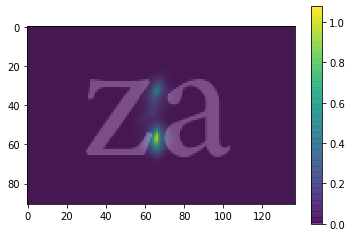

Word openness losses


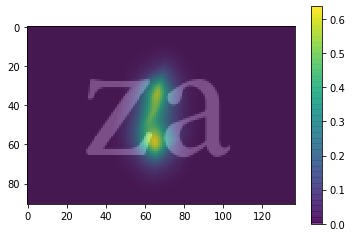

word weights, total_openness


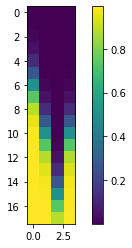

letter weights, total_openness


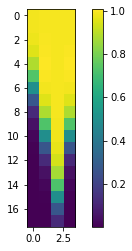

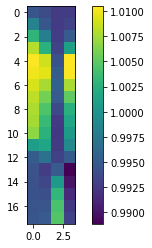

Exp: tf.Tensor(1.0, shape=(), dtype=float32)


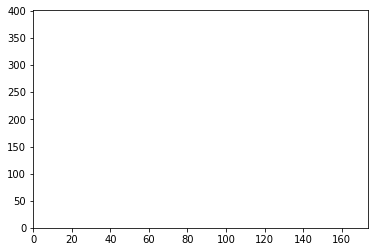

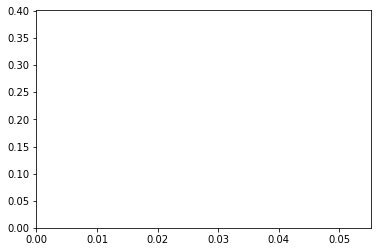

Total letter openness losses: [[173.59009 109.91638  68.0508 ]]
Total word openness losses: [[401.3894  342.18256 280.68042]]
Scores: [-6.8765625e-02 -3.0756008e-02  2.9115472e-06]


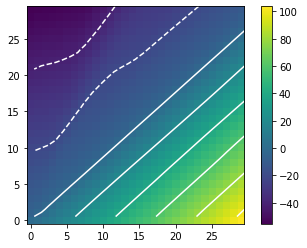

20/20 [==============================] - 6s 295ms/step - loss: 10.4168 - val_loss: 0.0907
Epoch 6/1000
20/20 [==============================] - 3s 129ms/step - loss: 11.1824
Epoch 7/1000
20/20 [==============================] - 2s 119ms/step - loss: 11.2669
Epoch 8/1000
20/20 [==============================] - 2s 120ms/step - loss: 8.4362
Epoch 9/1000
20/20 [==============================] - 2s 119ms/step - loss: 8.2538
Epoch 10/1000
19/20 [===========================>..] - ETA: 0s - loss: 7.3049Letter openness losses


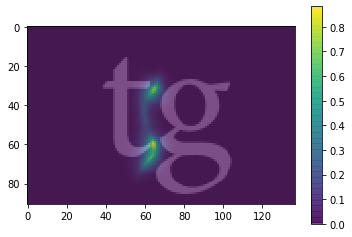

Word openness losses


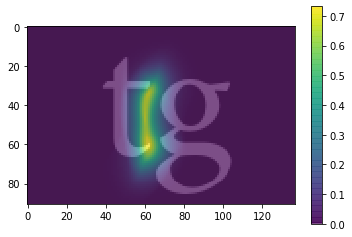

word weights, total_openness


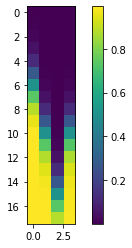

letter weights, total_openness


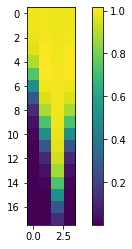

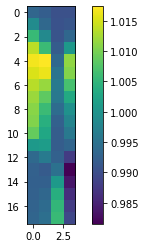

Exp: tf.Tensor(1.0, shape=(), dtype=float32)


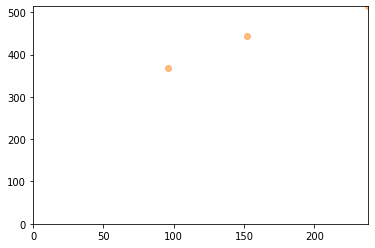

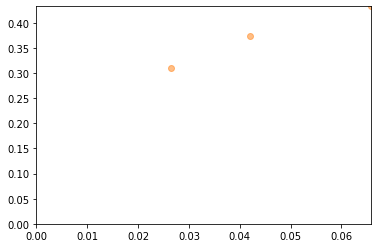

Total letter openness losses: [[238.14775  152.14992   95.730125]]
Total word openness losses: [[513.749   444.05603 368.34918]]
Scores: [-0.03650483  0.00250211  0.03115522]


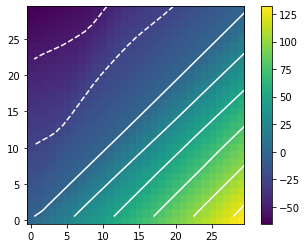

20/20 [==============================] - 6s 293ms/step - loss: 7.0207 - val_loss: 1.6130
Epoch 11/1000
20/20 [==============================] - 3s 128ms/step - loss: 7.4994
Epoch 12/1000
20/20 [==============================] - 2s 117ms/step - loss: 5.3145
Epoch 13/1000
20/20 [==============================] - 2s 119ms/step - loss: 12.7940
Epoch 14/1000
20/20 [==============================] - 2s 118ms/step - loss: 3.5253
Epoch 15/1000
19/20 [===========================>..] - ETA: 0s - loss: 4.7685Letter openness losses


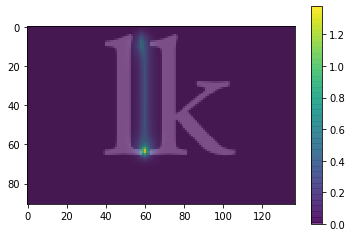

Word openness losses


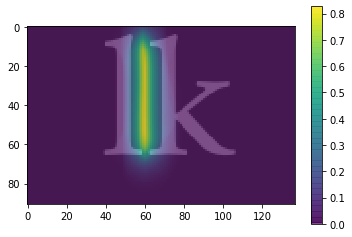

word weights, total_openness


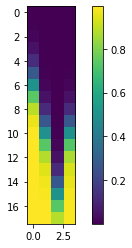

letter weights, total_openness


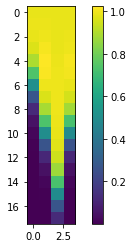

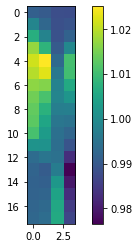

Exp: tf.Tensor(1.0, shape=(), dtype=float32)


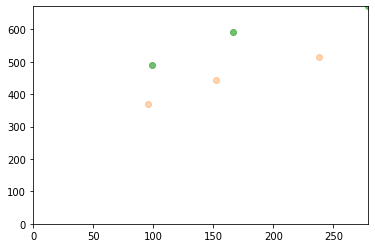

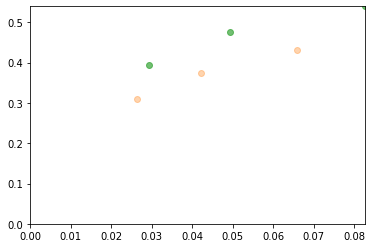

Total letter openness losses: [[278.77777  166.73427   98.663055]]
Total word openness losses: [[670.762  590.5959 489.6227]]
Scores: [-0.07930414 -0.02553236  0.00921673]


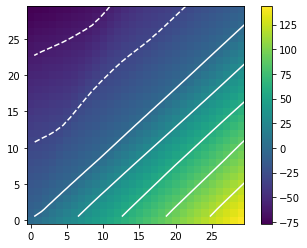

20/20 [==============================] - 6s 288ms/step - loss: 4.8867 - val_loss: 11.3548
Epoch 16/1000
20/20 [==============================] - 3s 128ms/step - loss: 2.9702
Epoch 17/1000
20/20 [==============================] - 2s 118ms/step - loss: 4.5599
Epoch 18/1000
20/20 [==============================] - 2s 118ms/step - loss: 3.3601
Epoch 19/1000
20/20 [==============================] - 2s 119ms/step - loss: 8.9350
Epoch 20/1000
19/20 [===========================>..] - ETA: 0s - loss: 15.1690Letter openness losses


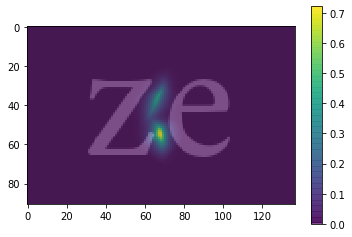

Word openness losses


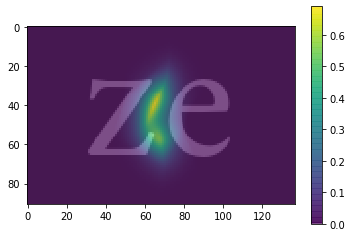

word weights, total_openness


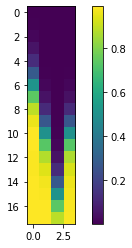

letter weights, total_openness


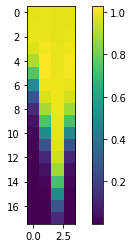

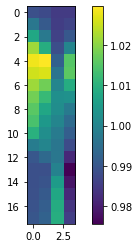

Exp: tf.Tensor(1.0, shape=(), dtype=float32)


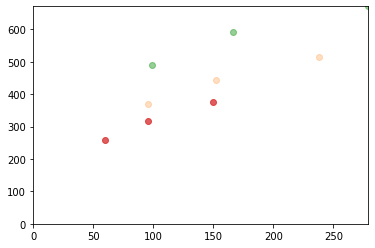

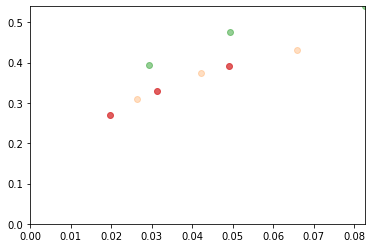

Total letter openness losses: [[150.23314   95.93116   60.073914]]
Total word openness losses: [[375.17715 316.97375 258.87146]]
Scores: [0.00472225 0.03943267 0.06406014]


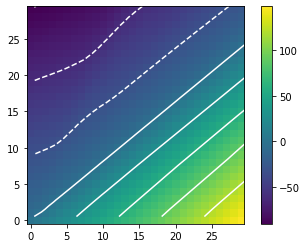

20/20 [==============================] - 6s 296ms/step - loss: 14.6006 - val_loss: 17.2938
Epoch 21/1000
20/20 [==============================] - 3s 128ms/step - loss: 7.7459
Epoch 22/1000
20/20 [==============================] - 2s 118ms/step - loss: 7.8424
Epoch 23/1000
20/20 [==============================] - 2s 116ms/step - loss: 9.1486
Epoch 24/1000
20/20 [==============================] - 2s 119ms/step - loss: 6.8231
Epoch 25/1000
19/20 [===========================>..] - ETA: 0s - loss: 10.6660Letter openness losses


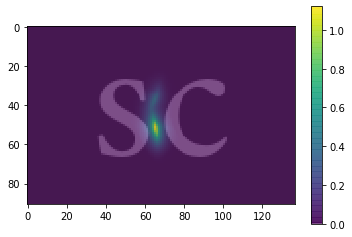

Word openness losses


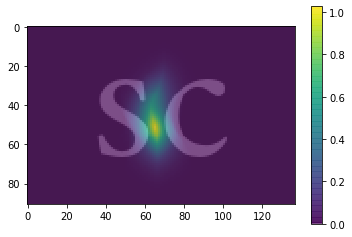

word weights, total_openness


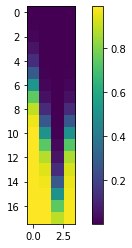

letter weights, total_openness


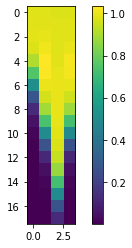

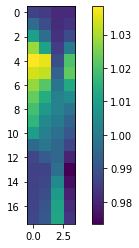

Exp: tf.Tensor(1.0, shape=(), dtype=float32)


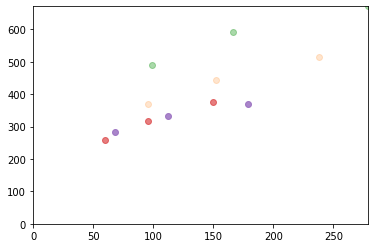

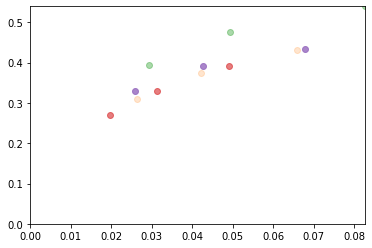

Total letter openness losses: [[178.99382 112.54117  68.50302]]
Total word openness losses: [[370.79688 333.04416 281.6836 ]]
Scores: [-0.07891017 -0.02198411  0.01889236]


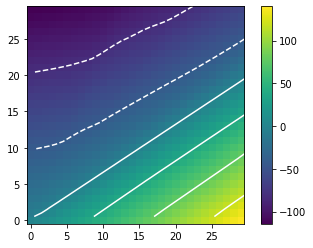

20/20 [==============================] - 6s 287ms/step - loss: 10.1348 - val_loss: 5.9766
Epoch 26/1000
20/20 [==============================] - 3s 128ms/step - loss: 5.5928
Epoch 27/1000
20/20 [==============================] - 2s 120ms/step - loss: 3.9397
Epoch 28/1000
20/20 [==============================] - 2s 118ms/step - loss: 6.1416
Epoch 29/1000
20/20 [==============================] - 2s 116ms/step - loss: 2.6872
Epoch 30/1000
19/20 [===========================>..] - ETA: 0s - loss: 9.3653Letter openness losses


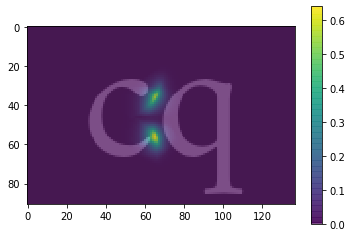

Word openness losses


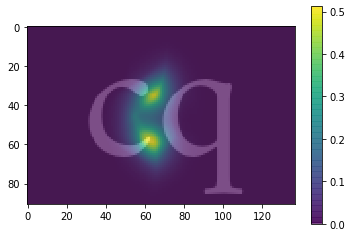

word weights, total_openness


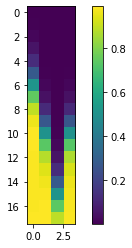

letter weights, total_openness


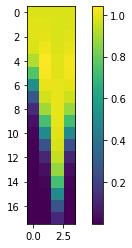

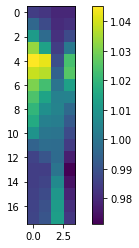

Exp: tf.Tensor(1.0, shape=(), dtype=float32)


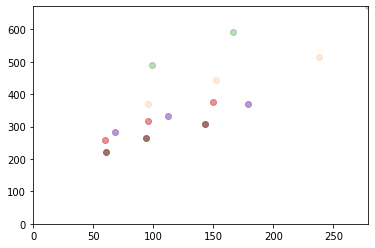

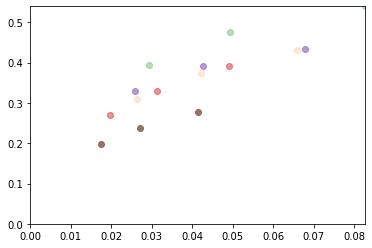

Total letter openness losses: [[143.02151  93.9082   60.50573]]
Total word openness losses: [[308.29584 264.66364 220.57935]]
Scores: [0.00707732 0.03949947 0.06185006]


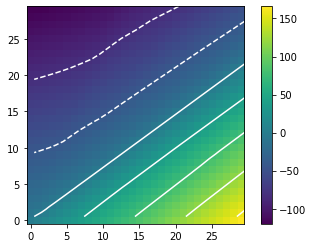

20/20 [==============================] - 6s 289ms/step - loss: 9.4147 - val_loss: 11.5505
Epoch 31/1000
20/20 [==============================] - 3s 130ms/step - loss: 8.9444
Epoch 32/1000
20/20 [==============================] - 2s 118ms/step - loss: 3.8644
Epoch 33/1000
20/20 [==============================] - 2s 120ms/step - loss: 6.2140
Epoch 34/1000
20/20 [==============================] - 2s 121ms/step - loss: 5.0358
Epoch 35/1000
19/20 [===========================>..] - ETA: 0s - loss: 6.8802Letter openness losses


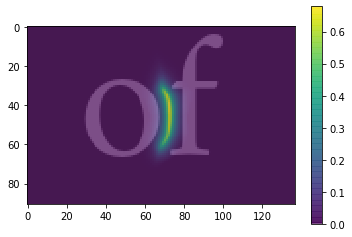

Word openness losses


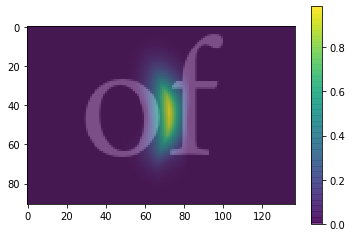

word weights, total_openness


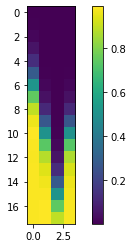

letter weights, total_openness


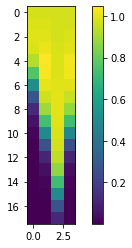

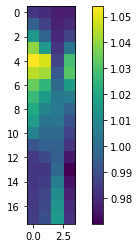

Exp: tf.Tensor(1.0, shape=(), dtype=float32)


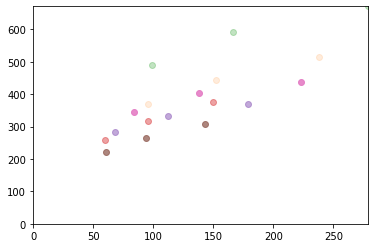

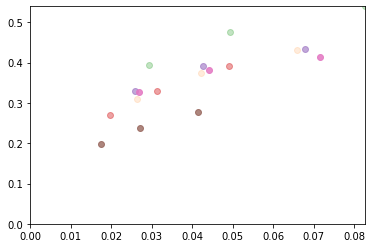

Total letter openness losses: [[222.95462 137.86293  84.0889 ]]
Total word openness losses: [[438.7389  403.44202 345.87946]]
Scores: [-0.05257956  0.01139607  0.048739  ]


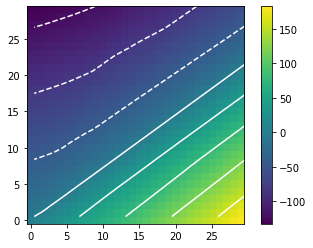

20/20 [==============================] - 6s 300ms/step - loss: 7.5885 - val_loss: 1.2210
Epoch 36/1000
20/20 [==============================] - 3s 128ms/step - loss: 8.1395
Epoch 37/1000
20/20 [==============================] - 2s 119ms/step - loss: 6.6978
Epoch 38/1000
20/20 [==============================] - 2s 119ms/step - loss: 4.9180
Epoch 39/1000
20/20 [==============================] - 2s 117ms/step - loss: 4.4256
Epoch 40/1000
19/20 [===========================>..] - ETA: 0s - loss: 8.6995Letter openness losses


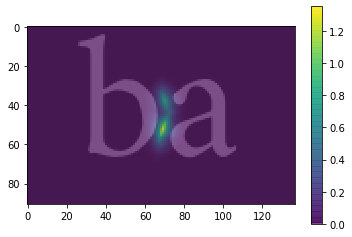

Word openness losses


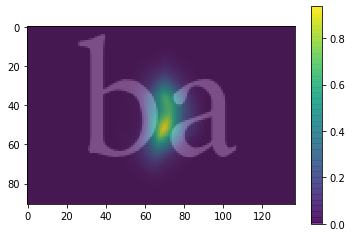

word weights, total_openness


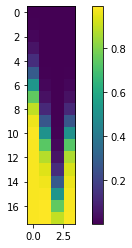

letter weights, total_openness


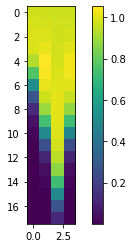

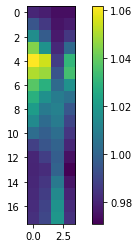

Exp: tf.Tensor(1.0, shape=(), dtype=float32)


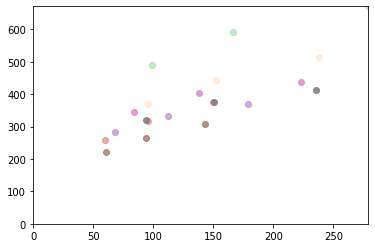

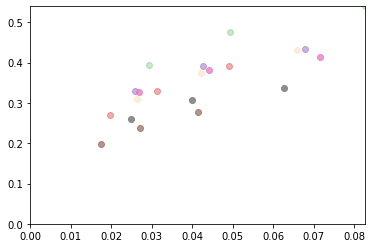

Total letter openness losses: [[235.68848 150.32281  93.63896]]
Total word openness losses: [[414.21362 376.03122 319.66055]]
Scores: [-0.04745471  0.01033079  0.04544232]


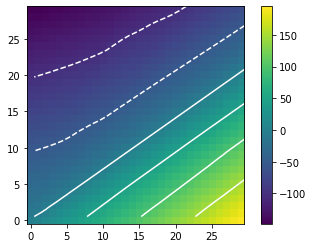

20/20 [==============================] - 6s 287ms/step - loss: 8.4950 - val_loss: 1.9239
Epoch 41/1000
20/20 [==============================] - 3s 129ms/step - loss: 5.4725
Epoch 42/1000
20/20 [==============================] - 2s 118ms/step - loss: 5.7650
Epoch 43/1000
20/20 [==============================] - 2s 120ms/step - loss: 5.3185
Epoch 44/1000
20/20 [==============================] - 2s 117ms/step - loss: 5.1385
Epoch 45/1000
19/20 [===========================>..] - ETA: 0s - loss: 4.5249Letter openness losses


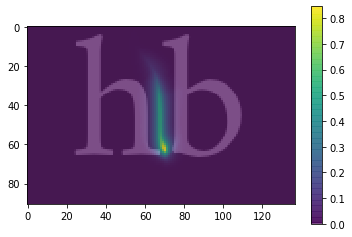

Word openness losses


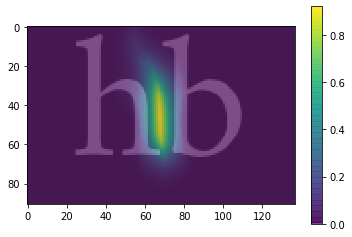

word weights, total_openness


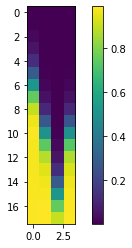

letter weights, total_openness


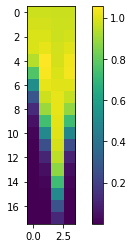

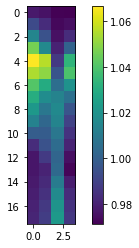

Exp: tf.Tensor(1.0, shape=(), dtype=float32)


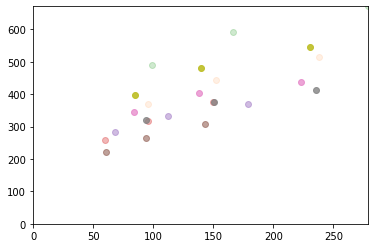

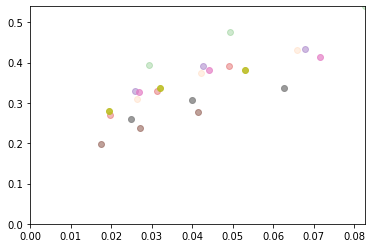

Total letter openness losses: [[230.99197 140.03258  84.48752]]
Total word openness losses: [[546.10596 482.12744 398.61584]]
Scores: [-0.05540308  0.00236094  0.0357186 ]


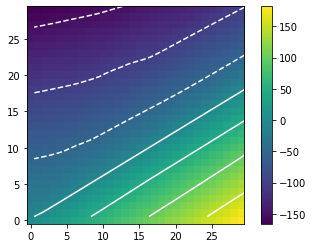

20/20 [==============================] - 6s 290ms/step - loss: 4.9708 - val_loss: 9.5968
Epoch 46/1000
20/20 [==============================] - 3s 132ms/step - loss: 7.7372
Epoch 47/1000
20/20 [==============================] - 2s 123ms/step - loss: 4.7758
Epoch 48/1000
20/20 [==============================] - 2s 122ms/step - loss: 6.0977
Epoch 49/1000
20/20 [==============================] - 2s 122ms/step - loss: 6.2801
Epoch 50/1000
19/20 [===========================>..] - ETA: 0s - loss: 3.4268Letter openness losses


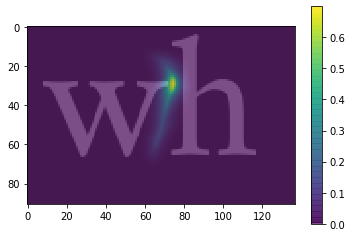

Word openness losses


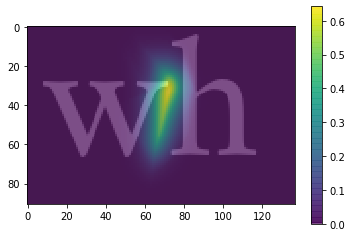

word weights, total_openness


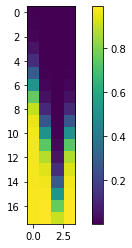

letter weights, total_openness


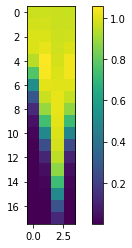

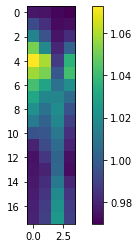

Exp: tf.Tensor(1.0, shape=(), dtype=float32)


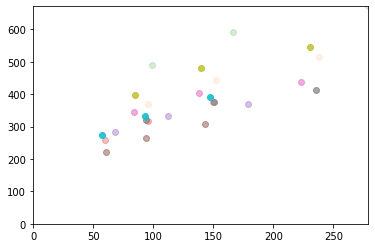

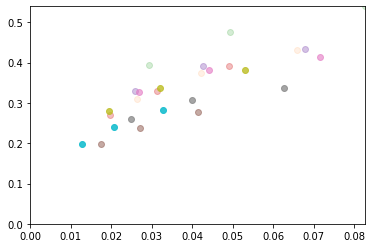

Total letter openness losses: [[147.57573  92.91431  57.58966]]
Total word openness losses: [[391.23642 333.10046 273.36688]]
Scores: [0.0084866  0.03918254 0.05674329]


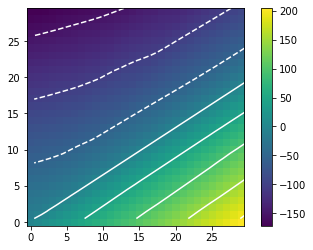

20/20 [==============================] - 6s 302ms/step - loss: 3.7960 - val_loss: 2.7859
Epoch 51/1000
20/20 [==============================] - 3s 129ms/step - loss: 3.1493
Epoch 52/1000
20/20 [==============================] - 2s 118ms/step - loss: 5.0195
Epoch 53/1000
20/20 [==============================] - 2s 120ms/step - loss: 4.3102
Epoch 54/1000
20/20 [==============================] - 2s 120ms/step - loss: 4.6457
Epoch 55/1000
19/20 [===========================>..] - ETA: 0s - loss: 4.5483Letter openness losses


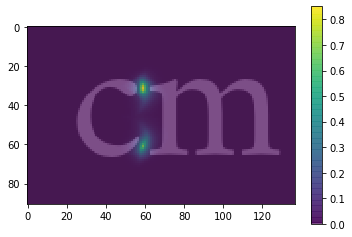

Word openness losses


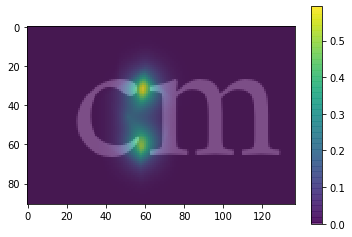

word weights, total_openness


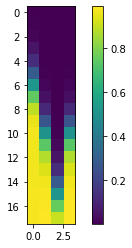

letter weights, total_openness


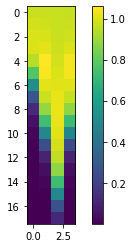

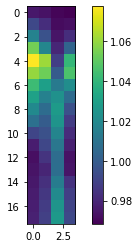

Exp: tf.Tensor(1.0, shape=(), dtype=float32)


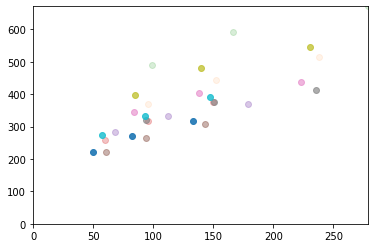

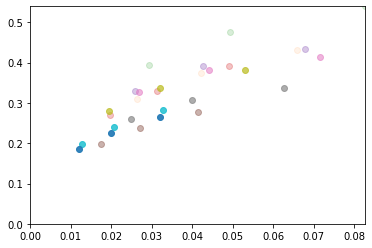

Total letter openness losses: [[133.0697    82.269905  50.241997]]
Total word openness losses: [[316.77325 269.6806  221.47998]]
Scores: [0.02937609 0.0578346  0.07169338]


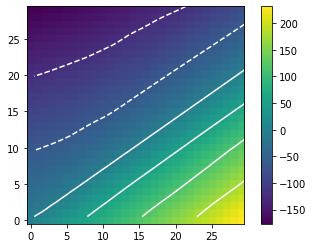

20/20 [==============================] - 6s 296ms/step - loss: 4.4316 - val_loss: 21.0024
Epoch 56/1000
20/20 [==============================] - 3s 130ms/step - loss: 5.9892
Epoch 57/1000
20/20 [==============================] - 2s 121ms/step - loss: 2.8334
Epoch 58/1000
20/20 [==============================] - 2s 118ms/step - loss: 2.7739
Epoch 59/1000
18/20 [==========================>...] - ETA: 0s - loss: 3.1574

KeyboardInterrupt: ignored

In [11]:
full_shape = ( n_sizes, n_orientations, box_height, box_width, n_sample_distances)

eps = np.finfo(np.float32).tiny

def invsp(t):
    if t == 0:
        return -1e10
    else:
        return np.log(np.exp(t) - 1).astype(np.float32)

def sp(t):
    return tf.nn.softplus(t)

class Openness(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Openness, self).__init__(**kwargs)

        overall_scale_default = np.ones((1, n_sizes, n_orientations, 1, 1, 1)) * invsp(1.)

        defw = np.ones((1, n_sizes, n_orientations, 1, 1, 1)) * 0.01
        if self.name == "letter_openness":
            defw[0, 0:5, 0, 0, 0, 0] = 0.05 #invsp(0.001)
        elif self.name == "total_openness":
            defw[0, :5, 0, 0, 0, 0] = -0.05 
            defw[0, 12:, 0, 0, 0, 0] = 0.05
        else:
            defw[0, 12:, 0, 0, 0, 0] = 0.05

        self.s = self.add_weight(shape=(1, n_sizes, n_orientations, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(overall_scale_default),
                                 name='s',
                                 trainable=True)
        self.c = self.add_weight(shape=(1, 1, n_orientations, 1, 1, 1), # cutoffs
                                 initializer=tf.keras.initializers.Constant(np.array([6, 10, 15, 10])[None, None, :, None, None, None]),
                                 name='w',
                                 trainable=True)
        self.t = self.add_weight(shape=(1, 1, n_orientations, 1, 1, 1), # cutoffs
                                 initializer=tf.keras.initializers.Constant(np.array([1, 1, 1, 1])[None, None, :, None, None, None]),
                                 name='t',
                                 trainable=True)

        self.e = self.add_weight(shape=(1, n_sizes, n_orientations, 1, 1, 1),
                                 initializer=tf.keras.initializers.Constant(invsp(1.)),
                                 name='e',
                                 trainable=True)

    def print_weights(self):
        w_w = sp(self.s) * tf.nn.sigmoid((np.arange(n_sizes)[None, :, None, None, None, None] - self.c) * self.t)
        l_w = sp(self.s) * (1 - tf.nn.sigmoid((np.arange(n_sizes)[None, :, None, None, None, None] - self.c) * self.t))
        print("word weights,", self.name)
        plt.imshow(w_w[0, :, :, 0, 0, 0])
        plt.colorbar()
        plt.show()
        print("letter weights,", self.name)
        plt.imshow(l_w[0, :, :, 0, 0, 0])
        plt.colorbar()
        plt.show()

        e = sp(self.e)
        plt.imshow(e[0, :, :, 0, 0, 0])
        plt.colorbar()
        plt.show()

    def call(self, inputs):
        w_w = sp(self.s) * tf.nn.sigmoid((np.arange(n_sizes)[None, :, None, None, None, None] - self.c) * self.t)
        l_w = sp(self.s) * (1 - tf.nn.sigmoid((np.arange(n_sizes)[None, :, None, None, None, None] - self.c) * self.t))
        e = sp(self.e)

        # Each neuron 
        w_k = (inputs * w_w + eps) ** e
        l_k = (inputs * l_w + eps) ** e

        return l_k, w_k

def get_os_model():
    sg1fi = tf.keras.Input(shape=full_shape, name='shifted_gd1_filtered_images', dtype=tf.complex64)
    sg2fi = tf.keras.Input(shape=full_shape, name='shifted_gd2_filtered_images', dtype=tf.complex64)
    sample_distances = tf.keras.Input(shape=(n_sample_distances), name='sample_distances')
    pair_images = tf.keras.Input(shape=(box_height, box_width, n_sample_distances), name='pair_images')
    zero_indices = tf.keras.Input(shape=(), name='zero_indices')

    #letter_openness = Openness(name="letter_openness")
    #word_openness = Openness(name="word_openness")
    #total_openness = Openness(name="total_openness")

    gmap = Gmap(name="gmap")
    
    gd1r_lo, gd1r_wo = total_openness(tf.nn.relu(tf.math.real(sg1fi)))
    gd1l_lo, gd1l_wo = total_openness(tf.nn.relu(-tf.math.real(sg1fi)))
    gd2r_lo, gd2r_wo = total_openness(tf.nn.relu(tf.math.real(sg2fi)))
    gd2l_lo, gd2l_wo = total_openness(tf.nn.relu(-tf.math.real(sg2fi)))
    pr_lo, pr_wo = total_openness(tf.nn.relu(tf.math.real(sg1fi + sg2fi)))
    pl_lo, pl_wo = total_openness(tf.nn.relu(-tf.math.real(sg1fi + sg2fi)))

    inner_lo = tf.identity(gd1r_lo + gd2l_lo, "inner_lo")
    inner_wo = tf.identity(gd1r_wo + gd2l_wo, "inner_wo")
    outer_lo = tf.identity(gd1l_lo + gd2r_lo, "outer_lo")
    outer_wo = tf.identity(gd1l_wo + gd2r_wo, "outer_wo")

    inner_lo

    unscaled_lol = tf.identity(tf.nn.relu(-(pr_lo + pl_lo - inner_lo - outer_lo)), "unscaled_lol")
    unscaled_wol = tf.identity(tf.nn.relu(-(pr_wo + pl_wo - inner_wo - outer_wo)), "unscaled_wol")

    lol_sum = tf.identity(tf.reduce_sum(unscaled_lol, [1,2,3,4]), "lol_sum")
    wol_sum = tf.identity(tf.reduce_sum(unscaled_wol, [1,2,3,4]), "wol_sum")
    
    lol_sum_scaled = tf.identity(lol_sum / tf.reduce_sum(inner_lo, [1,2,3,4]), "lol_sum_scaled")
    wol_sum_scaled = tf.identity(wol_sum / tf.reduce_sum(inner_wo, [1,2,3,4]), "wol_sum_scaled")

    dd = 3
    #slope_target = tf.keras.backend.variable(0.0, name="target_slope")
    #slope_tighter = (wol_sum[:, 1] - wol_sum[:, 0]) / (lol_sum[:, 1] - lol_sum[:, 0]) - slope_target
    #slope_looser = (wol_sum[:, 2] - wol_sum[:, 1]) / (lol_sum[:, 2] - lol_sum[:, 1]) - slope_target
    #best_slope_at = -dd*(slope_tighter + slope_looser) / (2 * (slope_looser - slope_tighter))

    #mid_slope_deviation = ((lol_sum[:, 1] - lol_sum[:, 0]) / (wol_sum[:, 1] - wol_sum[:, 0]) + (lol_sum[:, 2] - lol_sum[:, 1]) / (wol_sum[:, 2] - wol_sum[:, 1]) - tf.keras.backend.variable(0.0, name="target_slope")) ** 2

    ## Now what happens to the openness scores when we subtract 
    total_lol = tf.reshape(lol_sum_scaled, [batch_size * n_sample_distances, 1])
    total_wol = tf.reshape(wol_sum_scaled, [batch_size * n_sample_distances, 1])
    total_nnin = tf.concat([total_lol, total_wol], 1)
    
    l1 = tf.keras.layers.Dense(52, input_shape=(2,), name="os_l1", activation='elu')(total_nnin)
    l2 = tf.keras.layers.Dense(52, activation='elu')(l1)
    l3 = tf.keras.layers.Dense(32, activation='linear')(l2)
    l4 = tf.keras.layers.Dense(1, activation='linear', name="os_l4")(l3)

    scores = tf.identity(tf.reshape(l4, [batch_size, n_sample_distances]), "unscaled_scores")

    scores = tf.identity(scores / (eps + scores[:, 1]), "scores")

    #scores = best_slope_at ** 2

    return tf.keras.Model(inputs=[sg1fi,
                                  sg2fi,
                                  sample_distances, pair_images, zero_indices],
                                  outputs=(scores))

@tf.function
def compute_os_loss(_predicted, pair_response):
    if False:
        # We want the score for the middle to be the highest.
        down_first = (pair_response[:, 0] - pair_response[:, 1]) # negative if correct
        up_second = (pair_response[:, 2] - pair_response[:, 1]) 
    
        cost = tf.reduce_max(tf.stack([down_first, up_second], axis=-1), [-1])
    
        return tf.reduce_sum(cost)
    elif True:
        d = pair_response
        dd = 3
        constrained_slopes = (d[:, 1:] - d[:, 0:-1]) / dd # right now delta-x is equal spacing
        predicted_zeros = np.array([-dd, 0]) - d[:, 0:-1] / (eps + constrained_slopes)

        first_crosses_up = tf.nn.sigmoid(1000 * d[:, 1]) * tf.nn.sigmoid(-1000 * d[:, 0])
        second_crosses_up = tf.nn.sigmoid(1000 * d[:, 2]) * tf.nn.sigmoid(-1000 * d[:, 1])
        first_above_zero = tf.nn.sigmoid(1000 * d[:, 0])
        last_below_zero = tf.nn.sigmoid(-1000 * d[:, 2])
        relevance_first = tf.nn.tanh(1000 * (first_crosses_up + first_above_zero))
        relevance_last = tf.nn.tanh(1000 * (second_crosses_up + last_below_zero))

        predicted_zero = (relevance_first * predicted_zeros)[:, 0] + (relevance_last * predicted_zeros)[:, 1]
        return tf.reduce_sum(predicted_zero**2)
    else:
        return tf.reduce_sum(pair_response)

lols = []
wols = []
lols_scaled = []
wols_scaled = []
class MonitorOSProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, data_generator):
        self.data_generator = data_generator
        self.current_data = None

    def get_val(self, name):
        l = [l for l in os_model.layers if l.name.endswith(name)][0]
        output = tf.keras.backend.function(self.model.inputs, [l.output])(self.current_data)[0]
        return output

    def get_weights(self, name):
        l = [l for l in os_model.layers if l.name.endswith(name)][0]
        return l.get_weights()

    def print_weights(self, name):
        l = [l for l in os_model.layers if l.name.endswith(name)][0]
        l.print_weights()

    def on_test_batch_begin(self, batch_index, logs=None):
        dataset = self.data_generator[batch_index]
        current_data = dataset[0]
        self.current_data = current_data
        sg1fi, sg2fi, sample_distances, pair_images, zero_indices = current_data

        iix = 0

        print("Letter openness losses")
        plt.imshow(pair_images[iix, :, :, 1], cmap="gray", alpha=0.7)
        plt.imshow(tf.reduce_sum(self.get_val("lol")[iix, :, :, :, :, 1], [0, 1]), alpha=0.7)
        plt.colorbar()
        plt.show()

        print("Word openness losses")
        plt.imshow(pair_images[iix, :, :, 1], cmap="gray", alpha=0.7)
        plt.imshow(tf.reduce_sum(self.get_val("wol")[iix, :, :, :, :, 1], [0, 1]), alpha=0.7)
        plt.colorbar()
        plt.show()

        self.print_weights("total_openness")
        if True:
            lol = self.get_val("lol_sum")
            wol = self.get_val("wol_sum")
            lols.append(lol)
            wols.append(wol)
            fig, ax = plt.subplots()
            ax.set_xlim(0, np.max(np.array(lols)))
            ax.set_ylim(0, np.max(np.array(wols)))
            for ii, (ilol, iwol) in enumerate(zip(lols, wols)):
                ax.plot(ilol, iwol, alpha=1.*ii/len(lols))
                ax.scatter(ilol, iwol, alpha=1.*ii/len(lols))
            plt.show()
            lolsc = self.get_val("lol_sum_scaled")
            wolsc = self.get_val("wol_sum_scaled")
            lols_scaled.append(lolsc)
            wols_scaled.append(wolsc)
            fig, ax = plt.subplots()
            ax.set_xlim(0, np.max(np.array(lols_scaled)))
            ax.set_ylim(0, np.max(np.array(wols_scaled)))
            for ii, (ilol, iwol) in enumerate(zip(lols_scaled, wols_scaled)):
                ax.plot(ilol, iwol, alpha=1.*ii/len(lols))
                ax.scatter(ilol, iwol, alpha=1.*ii/len(lols))
            plt.show()
            print("Total letter openness losses:", lol)
            print("Total word openness losses:", wol)
            scores = self.get_val("scores")
            print("Scores:", self.get_val("scores")[0, :])
            #down_first = (scores[:, 0] - scores[:, 1]) # negative if correct
            #up_second = (scores[:, 2] - scores[:, 1]) 

            #cost = tf.reduce_max(tf.stack([down_first, up_second], axis=-1), [-1])
            #print("cost", cost)
    
            if True:
                ef_ingrid = np.reshape(np.einsum("dge->ged", np.mgrid[0:300:10, 0:600:20]), [-1, 2])
                ef1_l = [l for l in os_model.layers if l.name.endswith("os_l1")][0]
                ef3_l = [l for l in os_model.layers if l.name.endswith("os_l4")][0]
                effective_values = np.reshape(tf.keras.backend.function(ef1_l.input, [ef3_l.output])(ef_ingrid)[0], [30, 30])
                plt.imshow(effective_values, origin='lower')
                plt.colorbar()
                plt.contour(effective_values, colors='w', origin='lower')
                plt.show()


tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()

ig = InputGenerator(batch_size)
if True:
    os_model = get_os_model()
    os_model.compile(loss=compute_os_loss,
                optimizer=tf.keras.optimizers.Adam(0.0004))
    testing = False
    history = os_model.fit_generator(ig,
                                callbacks=[MonitorOSProgressCallback(ig)],
                                validation_data=ig,
                                validation_steps=1,
                                validation_freq=(1 if testing else 5),
                                epochs=(1 if testing else 1000),
                                steps_per_epoch=(1 if testing else 20), use_multiprocessing=False)
ig.kill()
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()


## Alternative 1: a model based on direct letter and gap detection

In [0]:
full_shape = ( n_sizes, n_orientations, box_height, box_width, n_sample_distances)

eps = np.finfo(np.float32).tiny

def invsp(t):
    if t == 0:
        return -1e10
    else:
        return np.log(np.exp(t) - 1).astype(np.float32)

class LetterDetector(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(LetterDetector, self).__init__(**kwargs)

        self.c = self.add_weight(shape=(4),
                                 initializer=tf.keras.initializers.Constant(np.array([invsp(1), invsp(3), invsp(0.15), invsp(1.)])),
                                 name='c',
                                 trainable=True)

        self.ltf = self.add_weight(shape=(1, 1, 1, 1, 2*box_height, 2*box_width),           # Letter tuning function
                                       initializer=tf.keras.initializers.Constant(1.0),
                                       name='ltf',
                                       trainable=False)

        self.letter_exp = self.add_weight(shape=(),
                                       initializer=tf.keras.initializers.Constant(invsp(16.0)),
                                       name='letter_exp',
                                       trainable=True)
        self.letter_beta = self.add_weight(shape=(),
                                       initializer=tf.keras.initializers.Constant(invsp(.015)),
                                       name='letter_beta',
                                       trainable=True)
        self.letter_factor = self.add_weight(shape=(),
                                       initializer=tf.keras.initializers.Constant(invsp(1.)),
                                       name='letter_factor',
                                       trainable=True)
        
        y, x = np.mgrid[-box_height:box_height, -box_width:box_width].astype(np.float32)
        self.freq = np.sqrt(y**2 + x**2)
        self.angle = np.arctan2(y, x)

    def get_ltf(self):
        ltf_unscaled = tf.signal.ifftshift(tf.nn.softplus(self.c[0]) * self.freq**tf.nn.softplus(self.c[1]) * tf.exp(-tf.nn.softplus(self.c[2]) * self.freq) * tf.abs(tf.exp(self.c[3] * tf.sin(self.angle)**2)))[None, None, None, None, :, :]
        return ltf_unscaled / (eps + tf.reduce_max(ltf_unscaled))

    def print_weights(self):
        print("Letter tuning function:", tf.nn.softplus(self.c[0]), tf.nn.softplus(self.c[1]), tf.nn.softplus(self.c[2]), self.c[3])
        print("Letter nonlinearity exponent:", tf.nn.softplus(self.letter_exp), "beta:", tf.nn.softplus(self.letter_beta), "factor:", tf.nn.softplus(self.letter_factor))

        ltf = self.get_ltf()
        cltf = tf.complex(ltf, tf.zeros_like(ltf))
        plt.imshow(tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(cltf)))[0, 0, 0, 0, :, :])
        plt.colorbar()
        plt.show()

    def call(self, inputs):
        [pair_fft_images, g_fft_images] = inputs   # both <bdsohw>

        ltf = self.get_ltf()
        cltf = tf.complex(ltf, tf.zeros_like(ltf)) 

        letter_area = tf.reduce_sum(tf.math.abs(tf.signal.ifft2d(cltf * g_fft_images)))

        response = 2 * tf.math.abs(tf.signal.fftshift(tf.signal.ifft2d(cltf * pair_fft_images * tf.math.conj(g_fft_images)), [4, 5])) / letter_area
        
        slexp, sbeta, sfactor = tf.nn.softplus(self.letter_exp), tf.nn.softplus(self.letter_beta), tf.nn.softplus(self.letter_factor)
        out = sfactor * response ** slexp / (eps + sbeta + response ** slexp)

        return out


class GapDetector(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GapDetector, self).__init__(**kwargs)

        self.c = self.add_weight(shape=(4),
                                 initializer=tf.keras.initializers.Constant(np.array([invsp(1), invsp(2), invsp(0.3), invsp(22)])),
                                 name='gtf_c',
                                 trainable=True)
        self.gtf = self.add_weight(shape=(1, 1, 1, 1, 2*box_height, 2*box_width),           # Gap tuning function
                                       initializer=tf.keras.initializers.Constant(1.0),
                                       name='gtf',
                                       trainable=False)
        self.gap_exp = self.add_weight(shape=(),
                                       initializer=tf.keras.initializers.Constant(invsp(2.0)),
                                       name='gap_exp',
                                       trainable=False)
        self.gap_beta = self.add_weight(shape=(),
                                       initializer=tf.keras.initializers.Constant(invsp(1.0)),
                                       name='gap_beta',
                                       trainable=True)

        y, x = np.mgrid[-box_height:box_height, -box_width:box_width].astype(np.float32)
        self.angle = np.arctan2(y, x)
        self.freq = np.sqrt(y**2 + x**2)

    def get_gtf(self):
        gtf_unscaled = tf.signal.ifftshift(tf.nn.softplus(self.c[0]) * self.freq**tf.nn.softplus(self.c[1]) * tf.exp(-tf.nn.softplus(self.c[2]) * self.freq) * tf.abs(tf.cos(self.angle) + eps) ** tf.nn.softplus(self.c[3]))[None, None, None, None, :, :]
        return gtf_unscaled

    def print_weights(self):
        print("Gap tuning function:", tf.nn.softplus(self.c[0]), tf.nn.softplus(self.c[1]).numpy(), tf.nn.softplus(self.c[2]).numpy(), tf.nn.softplus(self.c[3]).numpy())
        print("Gap nonlinearity exponent:", tf.nn.softplus(self.gap_exp), "beta:", tf.nn.softplus(self.gap_beta))
        plt.imshow(tf.signal.fftshift(tf.math.imag(tf.signal.ifft2d(tf.complex(tf.zeros_like(self.get_gtf()), -self.get_gtf())[0, 0, 0, 0, :, :]))))
        plt.colorbar()
        plt.show()

    def call(self, inputs):
        [pair_fft_images, left_fft_images, right_fft_images] = inputs   # both <bdsohw>
        
        gtf = self.get_gtf()
        cgtf = tf.complex(tf.zeros_like(gtf), -gtf)

        # We don't want to include the impact of the outside gaps. Although we can technically include them,
        # they often overwhelm the calculation, and by getting less strong

        bothgaps = tf.nn.relu(tf.math.imag(tf.signal.ifft2d(cgtf * pair_fft_images)))

        sgexp = tf.nn.softplus(self.gap_exp)
        gbeta = tf.nn.softplus(self.gap_beta)
        response = (eps + bothgaps)  ** sgexp / (eps + gbeta ** sgexp + bothgaps ** sgexp)

        return response


class PairDetector(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(PairDetector, self).__init__(**kwargs)

        self.left_detector = self.add_weight(shape=(2*box_height, 2*box_width),
                                       initializer=tf.keras.initializers.Constant(1.0),
                                       name='gtf',
                                       trainable=False)
        
        self.pair_distance = self.add_weight(shape=(),
                                             initializer=tf.keras.initializers.Constant(1.),
                                             name='pair_distance',
                                             trainable=True)
        self.distractor_distance = self.add_weight(shape=(),
                                             initializer=tf.keras.initializers.Constant(1.),
                                             name='distractor_distance',
                                             trainable=True)
        self.pair_sigma = self.add_weight(shape=(),
                                             initializer=tf.keras.initializers.Constant(1.),
                                             name='pair_sigma',
                                             trainable=True)
        self.exp = self.add_weight(shape=(),
                                             initializer=tf.keras.initializers.Constant(2.1),
                                             name='pair_exp',
                                             trainable=True)
        self.gf = self.add_weight(shape=(),
                                             initializer=tf.keras.initializers.Constant(1.5),
                                             name='gap_factor',
                                             trainable=True)
        self.beta = self.add_weight(shape=(),
                                             initializer=tf.keras.initializers.Constant(15),
                                             name='pair_beta',
                                             trainable=True)
    
    def get_detectors(self):
        y, x = np.mgrid[-box_height:box_height, -box_width:box_width].astype(np.float32)
        left_detector = tf.exp(-tf.sqrt((x + (40 * self.pair_distance) / 2)**2 + y**2 + eps) / (eps + (self.pair_sigma * 4)**2))
        right_detector = tf.exp(-tf.sqrt((x - (40 * self.pair_distance) / 2)**2 + y**2 + eps) / (eps + (self.pair_sigma * 4)**2))
        left_distractor_detector = tf.exp(-tf.sqrt((x + (20 * self.distractor_distance) / 2)**2 + y**2 + eps) / (eps + (self.pair_sigma * 4)**2))
        right_distractor_detector = tf.exp(-tf.sqrt((x - (20 * self.distractor_distance) / 2)**2 + y**2 + eps) / (eps + (self.pair_sigma * 4)**2))

        if False:
            left_detector = (self.left_detector * (box_height * box_width))**2
            #left_detector = left_detector_unscaled / (eps + tf.reduce_max(left_detector_unscaled))
            right_detector = tf.reverse(left_detector, [1])

        return (tf.signal.fft2d(tf.complex(left_detector, tf.zeros_like(left_detector)))[None, None, None, None, :, :],
                tf.signal.fft2d(tf.complex(right_detector, tf.zeros_like(right_detector)))[None, None, None, None, :, :],
                tf.signal.fft2d(tf.complex(left_distractor_detector, tf.zeros_like(left_distractor_detector)))[None, None, None, None, :, :],
                tf.signal.fft2d(tf.complex(right_distractor_detector, tf.zeros_like(right_distractor_detector)))[None, None, None, None, :, :])


    def print_weights(self):
        ld, rd, ldd, rdd = self.get_detectors()
        print("distances", self.pair_distance, self.distractor_distance, self.pair_sigma)
        print("Left detector function (real), beta:", tf.nn.softplus(self.beta) * 10, "exp:", tf.nn.softplus(self.exp).numpy(), tf.nn.softplus(self.gf).numpy())
        plt.imshow(tf.math.real(tf.signal.ifft2d(ld)[0, 0, 0, 0, :, :]))
        plt.colorbar()
        plt.show()
        print("Right detector function (real):")
        plt.imshow(tf.math.real(tf.signal.ifft2d(rd)[0, 0, 0, 0, :, :]))
        plt.colorbar()
        plt.show()
        print("Left D detector function (real)")
        plt.imshow(tf.math.real(tf.signal.ifft2d(ldd)[0, 0, 0, 0, :, :]))
        plt.colorbar()
        plt.show()
        print("Right D detector function (real):")
        plt.imshow(tf.math.real(tf.signal.ifft2d(rdd)[0, 0, 0, 0, :, :]))
        plt.colorbar()
        plt.show()

    def call(self, inputs):
        [g1_response, g2_response, gap_response] = inputs

        g1_response_fft = tf.signal.fft2d(tf.complex(g1_response, tf.zeros_like(g1_response)))
        g2_response_fft = tf.signal.fft2d(tf.complex(g2_response, tf.zeros_like(g2_response)))
        gap_response_fft = tf.signal.fft2d(tf.complex(gap_response, tf.zeros_like(gap_response)))

        left_detector, right_detector, ldd, rdd = self.get_detectors()

        sexp = tf.nn.softplus(self.exp) * 1
        sbeta = tf.nn.softplus(self.beta) * 10
        sgf = tf.nn.softplus(self.gf)

        # Compute g1-g2 response (the target)
        target_response_a = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(g1_response_fft * tf.math.conj(left_detector) + g2_response_fft * tf.math.conj(right_detector)), [4, 5])) ** sexp
        inverse_target_response_a = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(g2_response_fft * tf.math.conj(left_detector) + g1_response_fft * tf.math.conj(right_detector)), [4, 5])) ** sexp
        left_outside_response_a = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(gap_response_fft * tf.math.conj(ldd) + g1_response_fft * tf.math.conj(rdd)), [4, 5])) ** sexp
        left_distractor_response_a = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(g1_response_fft * tf.math.conj(ldd) + gap_response_fft * tf.math.conj(rdd)), [4, 5])) ** sexp
        right_outside_response_a = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(g2_response_fft * tf.math.conj(ldd) + gap_response_fft * tf.math.conj(rdd)), [4, 5])) ** sexp
        right_distractor_response_a = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(gap_response_fft * tf.math.conj(ldd) + g2_response_fft * tf.math.conj(rdd)), [4, 5])) ** sexp

        gap_left = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(gap_response_fft * tf.math.conj(ldd)), [4, 5]))
        gap_right = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(gap_response_fft * tf.math.conj(rdd)), [4, 5]))
        g1_left = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(g1_response_fft * tf.math.conj(ldd)), [4, 5]))
        g1_right = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(g1_response_fft * tf.math.conj(rdd)), [4, 5]))
        g2_left = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(g2_response_fft * tf.math.conj(ldd)), [4, 5]))
        g2_right = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(g2_response_fft * tf.math.conj(rdd)), [4, 5]))
        tg1_left = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(g1_response_fft * tf.math.conj(left_detector)), [4, 5]))
        tg1_right = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(g1_response_fft * tf.math.conj(right_detector)), [4, 5])) 
        tg2_left = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(g2_response_fft * tf.math.conj(left_detector)), [4, 5]))
        tg2_right = tf.math.real(tf.signal.fftshift(tf.signal.ifft2d(g2_response_fft * tf.math.conj(right_detector)), [4, 5])) 

        left_distractor_response = g1_left * gap_right
        right_outside_response = g2_left * gap_right
        left_outside_response = gap_left * g1_right
        right_distractor_response = gap_left * g2_right
        target_response = tg1_left * tg2_right
        inverse_target_response = tg2_left * tg1_right

        dn_pool = (left_distractor_response** sexp +
                   right_distractor_response** sexp +
                   left_outside_response** sexp +
                   right_outside_response** sexp +
                   target_response** sexp +
                   inverse_target_response** sexp)

        dn_left_distractor = left_distractor_response** sexp / (eps + sbeta + sgf * dn_pool)
        dn_right_distractor = right_distractor_response** sexp / (eps + sbeta + sgf * dn_pool)

        # For now, just divide taget by distractors
        normalized_target = target_response** sexp / (eps + sbeta + sgf * dn_pool)
        
        return tf.stack([normalized_target, target_response, left_distractor_response, right_distractor_response, left_outside_response, right_outside_response])


def get_ld_model():
    shifted_gd1_fft_images = tf.keras.Input(shape=(n_sample_distances, 1, 1, 2*box_height, 2*box_width), name='shifted_gd1_fft_images', dtype=tf.complex64)
    shifted_gd2_fft_images = tf.keras.Input(shape=(n_sample_distances, 1, 1, 2*box_height, 2*box_width), name='shifted_gd2_fft_images', dtype=tf.complex64)
    gd1_fft_image = tf.keras.Input(shape=(1, 1, 1, 2*box_height, 2*box_width), name='gd1_fft_image', dtype=tf.complex64)
    gd2_fft_image = tf.keras.Input(shape=(1, 1, 1, 2*box_height, 2*box_width), name='gd2_fft_image', dtype=tf.complex64)
    pair_fft_images = shifted_gd1_fft_images + shifted_gd2_fft_images

    # Compute the response of the letter detectors
    letterDetector = LetterDetector()
    g1_response = tf.identity(letterDetector([pair_fft_images, gd1_fft_image]), "g1_response")
    g2_response = tf.identity(letterDetector([pair_fft_images, gd2_fft_image]), "g2_response")

    # Compute the response of the gap detector
    gapDetector = GapDetector()
    gap_response = tf.identity(gapDetector([pair_fft_images, shifted_gd1_fft_images, shifted_gd2_fft_images]), "gap_response")

    # Compute the responses of the pairs
    pairDetector = PairDetector()
    pair_response = tf.identity(pairDetector([g1_response, g2_response, gap_response]), name="pair_response")

    total_pair_response = tf.identity(tf.reduce_sum(pair_response[0, ...] / tf.reduce_sum(eps + pair_response[0, ...], axis=[1,2,3,4,5], keepdims=True), axis=[2, 3, 4, 5]), name="total_pair_response")

    # Not used for anything
    sample_distances = tf.keras.Input(shape=(n_sample_distances), name='sample_distances')
    pair_images = tf.keras.Input(shape=(box_height, box_width, n_sample_distances), name='pair_images')
    zero_indices = tf.keras.Input(shape=(), name='zero_indices')

    return tf.keras.Model(inputs=[shifted_gd1_fft_images,
                                  shifted_gd2_fft_images,
                                  gd1_fft_image,
                                  gd2_fft_image,
                                  sample_distances, pair_images, zero_indices],
                                  outputs=(total_pair_response))

@tf.function
def compute_ld_loss(_predicted, pair_response):
    # We want to maximize the pair response for the second pair.
    #down_first = tf.nn.softplus(pair_response[:, 0] - pair_response[:, 1]) ** 2 - tf.nn.softplus(0.) ** 2
    #up_second = tf.nn.softplus(pair_response[:, 2] - pair_response[:, 1]) ** 2 - tf.nn.softplus(0.) ** 2

    down_first = (pair_response[:, 0] - pair_response[:, 1]) # negative if correct
    up_second = (pair_response[:, 2] - pair_response[:, 1]) 

    # Both are negative:
    both_negative = tf.nn.sigmoid(-down_first * 1e9) * tf.nn.sigmoid(-up_second * 1e9)

    cost = both_negative * (tf.nn.relu(-down_first) + tf.nn.relu(-up_second)) + (1-both_negative) * (tf.nn.relu(down_first) ** 2 + tf.nn.relu(up_second) ** 2)

    return tf.reduce_sum(cost)


class MonitorLDProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, data_generator):
        self.data_generator = data_generator
        self.current_data = None

    def get_val(self, name):
        l = [l for l in ld_model.layers if l.name.endswith(name)][0]
        output = tf.keras.backend.function(self.model.inputs, [l.output])(self.current_data)[0]
        return output

    def get_weights(self, name):
        l = [l for l in ld_model.layers if l.name.endswith(name)][0]
        return l.get_weights()

    def print_weights(self, name):
        l = [l for l in ld_model.layers if l.name.endswith(name)][0]
        l.print_weights()

    def on_test_batch_begin(self, batch_index, logs=None):
        dataset = self.data_generator[batch_index]
        current_data = dataset[0]
        self.current_data = current_data
        shifted_gd1_fft_images, shifted_gd2_fft_images, gd1_fft_image, gd2_fft_image, sample_distances, pair_images, zero_indices = current_data

        iix = 0
        pair_image = tf.math.real(tf.signal.ifft2d((shifted_gd1_fft_images + shifted_gd2_fft_images)[iix, :, 0, 0, :, :]))

        self.print_weights("letter_detector")
        self.print_weights("gap_detector")
        self.print_weights("pair_detector")

        if True:
            print("Reponses (g1, g2, gap):")
            g1_response = self.get_val("g1_response")
            plt.imshow(pair_image[1, :, :], cmap='gray')
            plt.imshow(g1_response[iix, 1, 0, 0, :, :], alpha=0.7)
            plt.colorbar()
            plt.show()
            g2_response = self.get_val("g2_response")
            plt.imshow(pair_image[1, :, :], cmap='gray')
            plt.imshow(g2_response[iix, 1, 0, 0, :, :], alpha=0.7)
            plt.colorbar()
            plt.show()
            gap_response = self.get_val("gap_response")
            plt.imshow(pair_image[1, :, :], cmap='gray')
            plt.imshow(gap_response[iix, 1, 0, 0, :, :], alpha=0.7)
            plt.colorbar()
            plt.show()

        pair_response = self.get_val("pair_response")
        total_pair_response = self.get_val("total_pair_response")

        print("###################### total_pair_values:", total_pair_response[0, :])
        print("###################### pairs:", tf.reduce_sum(pair_response[1, iix, :, 0, 0, :, :], axis=[1,2]).numpy())
        print("###################### distractors:", tf.reduce_sum(pair_response[2:, iix, :, 0, 0, :, :], axis=[0, 2, 3]).numpy())
        
        if False:
            print("TOO CLOSE:")
            print("DN:")
            plt.imshow(pair_image[0, :, :], cmap='gray')
            plt.imshow(pair_response[0, iix, 0, 0, 0, :, :], alpha=0.7)
            plt.colorbar()
            plt.show()
            print("Pair detector response:")
            plt.imshow(pair_image[0, :, :], cmap='gray')
            plt.imshow(pair_response[1, iix, 0, 0, 0, :, :], alpha=0.7)
            plt.colorbar()
            plt.show()
            print("Left distractor detector response:")
            plt.imshow(pair_image[0, :, :], cmap='gray')
            plt.imshow(pair_response[2, iix, 0, 0, 0, :, :], alpha=0.7)
            plt.colorbar()
            plt.show()
            print("Right distractor detector response:")
            plt.imshow(pair_image[0, :, :], cmap='gray')
            plt.imshow(pair_response[3, iix, 0, 0, 0, :, :], alpha=0.7)
            plt.colorbar()
            plt.show()
            
        print("JUST RIGHT:")
        print("DN:")
        plt.imshow(pair_image[1, :, :], cmap='gray')
        plt.imshow(pair_response[0, iix, 1, 0, 0, :, :], alpha=0.7)
        plt.colorbar()
        plt.show()
        print("Pair detector response:")
        plt.imshow(pair_image[1, :, :], cmap='gray')
        plt.imshow(pair_response[1, iix, 1, 0, 0, :, :], alpha=0.7)
        plt.colorbar()
        plt.show()
        print("Left outside detector response:")
        plt.imshow(pair_image[1, :, :], cmap='gray')
        plt.imshow(pair_response[4, iix, 1, 0, 0, :, :], alpha=0.7)
        plt.colorbar()
        plt.show()
        print("Left DN distractor detector response:")
        plt.imshow(pair_image[1, :, :], cmap='gray')
        plt.imshow(pair_response[2, iix, 1, 0, 0, :, :], alpha=0.7)
        plt.colorbar()
        plt.show()
        print("Right DN distractor detector response:")
        plt.imshow(pair_image[1, :, :], cmap='gray')
        plt.imshow(pair_response[3, iix, 1, 0, 0, :, :], alpha=0.7)
        plt.colorbar()
        plt.show()
        print("Right outside detector response:")
        plt.imshow(pair_image[1, :, :], cmap='gray')
        plt.imshow(pair_response[5, iix, 1, 0, 0, :, :], alpha=0.7)
        plt.colorbar()
        plt.show()
        if True:
            print("TOO FAR:")
            print("DN:")
            plt.imshow(pair_image[2, :, :], cmap='gray')
            plt.imshow(pair_response[0, iix, 2, 0, 0, :, :], alpha=0.7)
            plt.colorbar()
            plt.show()
            print("Pair detector response:")
            plt.imshow(pair_image[2, :, :], cmap='gray')
            plt.imshow(pair_response[1, iix, 2, 0, 0, :, :], alpha=0.7)
            plt.colorbar()
            plt.show()
            print("Gap:")
            gap_response = self.get_val("gap_response")
            plt.imshow(pair_image[2, :, :], cmap='gray')
            plt.imshow(gap_response[iix, 2, 0, 0, :, :], alpha=0.7)
            plt.colorbar()
            plt.show()
            print("Left distractor detector response:")
            plt.imshow(pair_image[2, :, :], cmap='gray')
            plt.imshow(pair_response[2, iix, 2, 0, 0, :, :], alpha=0.7)
            plt.colorbar()
            plt.show()
            print("Right distractor detector response:")
            plt.imshow(pair_image[2, :, :], cmap='gray')
            plt.imshow(pair_response[3, iix, 2, 0, 0, :, :], alpha=0.7)
            plt.colorbar()
            plt.show()


tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()

ig = InputGenerator(batch_size)
if False:
    ld_model = get_ld_model()
    ld_model.compile(loss=compute_ld_loss,
                optimizer=tf.keras.optimizers.Adagrad(0.03))
    testing = False
    history = ld_model.fit_generator(ig,
                                callbacks=[MonitorLDProgressCallback(ig)],
                                validation_data=ig,
                                validation_steps=1,
                                validation_freq=(1 if testing else 40),
                                epochs=(1 if testing else 1000),
                                steps_per_epoch=(1 if testing else 40), use_multiprocessing=False)
ig.kill()
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()

Creating glyph images ...


100%|██████████| 26/26 [00:09<00:00,  2.86it/s]


## Alternative 2: Model evaluator

In [0]:
tf.keras.backend.clear_session()  # For easy reset of notebook state.
full_shape = ( n_sizes, n_orientations, box_height, box_width, n_sample_distances)

eps = np.finfo(np.float32).tiny

@tf.function
def nd_softmax(target, axis, name=None):
    max_axis = tf.reduce_max(target, axis, keepdims=True)
    target_exp = tf.exp(target - max_axis)
    normalize = tf.reduce_sum(target_exp, axis, keepdims=True)
    softmax = target_exp / (normalize + eps)
    return softmax


@tf.function
def sp(t):
    return tf.nn.softplus(t)
@tf.function
def tilo(t):
    return tf.concat([t[:, :, 0:1, :, :, :], t[:, :, 1:2, :, :, :], t[:, :, 2:3, :, :, :], t[:, :, 1:2, :, :, :]], axis=2)
@tf.function
def tilop(t):
    return tf.nn.softplus(tilo(t))
@tf.function
def ptilo(t):
    return tf.concat([t[:, :, 0:1, :, :, :, :], t[:, :, 1:2, :, :, :, :], t[:, :, 2:3, :, :, :, :], t[:, :, 1:2, :, :, :, :]], axis=2)
@tf.function
def ptilop(t):
    return tf.nn.softplus(ptilo(t))
@tf.function
def tiloa(t):
    return tf.concat([t[:, :, :, :, 0:1, :, :], t[:, :, :, :, 1:2, :, :], t[:, :, :, :, 2:3, :, :], t[:, :, :, :, 1:2, :, :]], axis=4)
@tf.function
def tiloap(t):
    return tf.nn.softplus(tiloa(t))
def invsp(t):
    if t == 0:
        return -1e10
    else:
        return np.log(np.exp(t) - 1).astype(np.float32)

def rectify_phases(inputs):
    # Inputs: <b, s, o, h, w, d>
    # Output: <b, s, o, p, h, w, d> where p is [0, 1, 2, 3]
    return tf.stack([tf.nn.relu(tf.math.real(inputs)),
                     tf.nn.relu(tf.math.imag(inputs)),
                     tf.nn.relu(-tf.math.real(inputs)),
                     tf.nn.relu(-tf.math.imag(inputs))], axis=3)

class BiasedAbs(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BiasedAbs, self).__init__(**kwargs)

        self.bias_weights = self.add_weight(shape=(1, n_sizes, n_orientations - 1, 1, 1, 1),
                                       initializer=tf.keras.initializers.Constant(0.),
                                       name='bias_weights',
                                       trainable=True)
        self.exponent = self.add_weight(shape=(), #(1, n_sizes, n_orientations - 1, 1, 1, 1),
                                       initializer=tf.keras.initializers.Constant(2.2),
                                       name='exponent',
                                       trainable=True)

    def print_weights(self):
        print(tf.nn.sigmoid(tilo(self.bias_weights))[0, :, :, 0, 0, 0])
        print("Exponents:", self.exponent)
        #plt.imshow(tilop(self.exponent)[0, :, :, 0, 0, 0])
        #plt.colorbar()
        #plt.show()

    def call(self, inputs):
        squashed_bias_weights = tf.nn.sigmoid(tilo(self.bias_weights))
        # 0.0 -> abs(real)
        # 0.5 -> abs(inputs)
        # 1.0 -> abs(imag)
        fr = 1. - squashed_bias_weights
        fi = squashed_bias_weights
        biased_abs = (tf.sqrt(eps + fr * tf.math.real(inputs)**2 + fi * tf.math.imag(inputs)**2) * tf.sqrt(2.)) ** (self.exponent)
        #biased_abs = tf.sqrt(eps + fr * (inputs[:, :, :, 0, :, :, :] - inputs[:, :, :, 2, :, :, :])**2 + fi * (inputs[:, :, :, 1, :, :, :] - inputs[:, :, :, 3, :, :, :])**2) * tf.sqrt(2.)

        return biased_abs

class NormalizationPool(tf.keras.layers.Layer):
    # This layer computes the unscaled normalization pool for each neuron.
    # It effectively performs a blur over space, frequency, and orientation, using
    # Gaussian blur via 3D FFT (instead of a convolutional layer) followed by
    # a matrix multiplication over the orientation axis (arbitrary kernel).
    #
    # The input is a 7D tensor of reals <b, s, o, p, y, x, d> (scale_index, orientation_index, phase_index, vertical coordinate, horizontal coordinate)
    # The output is a 7D tensor of reals <b, s, o, p, y, x, d> (scale_index, orientation_index, phase_index, vertical coordinate, horizontal coordinate)
    #
    # For more information, see Sawada & Petrov (2017)

    def __init__(self, **kwargs):
        super(NormalizationPool, self).__init__(**kwargs)

        self.sigmas = get_sigmas()
        self.wavelengths = self.get_wavelengths()
        self.r2grid, self.sgrid = self.get_distgrids()

        self.spatial_pool_size_factor = self.add_weight(shape=(),
                                                        initializer=tf.keras.initializers.Constant(1.),
                                                        name='spatial_pool_size_factor',
                                                        trainable=True)
        self.scale_pool_size_factor = self.add_weight(shape=(),
                                                      initializer=tf.keras.initializers.Constant(4.),
                                                      name='scale_pool_size_factor',
                                                      trainable=True)

        self.rescale_factor = self.add_weight(shape=(),
                                       initializer=tf.keras.initializers.Constant(-0.0),
                                       name='npool_rescale_factor',
                                       trainable=False)
        #self.phase_congruency_coefficient = self.add_weight(shape=(),
        #                                                      initializer=tf.keras.initializers.Constant(2.),
        #                                                      name="phase_congruency_coefficient",
        #                                                      trainable=True)

        # If this turns out to be symmetric, replace it with a von-Mises distribution
        # factor = exp(1.22 * cos(angle-diff)**2)  -- 1.22 coefficient taken from Sawada
        self.orientation_diff_matrix = np.array([[0, 45, 90, -45], [-45, 0, 45, 90], [90, -45, 0, 45], [45, 90, -45, 0]]).astype(np.float32) * np.pi / 180
        self.orientation_inhibition_coefficient = self.add_weight(shape=(),
                                                             initializer=tf.keras.initializers.Constant(1.22),
                                                             name='orientation_inhibition_coefficient',
                                                             trainable=True)

        # factor = exp(1.22 * sin(0.5 angle-diff)**2)  -- 1.22 coefficient taken from Sawada
        self.phase_diff_matrix = np.array([[0, 90, 180, -90], [-90, 0, 90, 180], [180, -90, 0, 90], [90, 180, -90, 0]]).astype(np.float32) * np.pi / 180
        self.phase_inhibition_coefficient = self.add_weight(shape=(),
                                                             initializer=tf.keras.initializers.Constant(1.0),
                                                             name='phase_inhibition_coefficient',
                                                             trainable=True)
        
        # Instead of an orientation inhibition matrix, we use a combined spatial/orientation filter.
        # Inhibition should be highest for orientations either in the opposition direction, or in the same direction but
        # aligned parallel.

        


    def print_weights(self):
        print("Spatial pool size factor", tf.nn.softplus(self.spatial_pool_size_factor.numpy()))
        print("Scale pool size factor", tf.nn.softplus(self.scale_pool_size_factor.numpy()))
        print("Rescale factor", self.rescale_factor)

        orientation_inhibition_matrix = tf.exp(self.orientation_inhibition_coefficient * tf.cos(self.orientation_diff_matrix)**2)
        phase_inhibition_matrix = tf.exp(self.phase_inhibition_coefficient * tf.sin(0.5 * self.phase_diff_matrix)**2)
        print("Orientation inhibition matrix")
        plt.imshow(orientation_inhibition_matrix.numpy())
        plt.colorbar()
        plt.show()
        print("Phase inhibition matrix")
        plt.imshow(phase_inhibition_matrix.numpy())
        plt.colorbar()
        plt.show()

    def get_wavelengths(self):
        sigmas = self.sigmas
        # We are padding to twice n_sizes
        padded_sigmas = [sigmas[0]] * int(np.ceil(n_sizes / 2)) + list(sigmas) + [sigmas[-1]] * int(n_sizes / 2)
        # Used for the distgrids, which are sorted <b, d, o, p, s, y, x> (because FFT works on innermost axes)
        return np.array(padded_sigmas).astype(np.float32)[None, None, None, None, :, None, None]
    
    def get_distgrids(self):
        # Computes the distance, spatially and in terms of log-wavelength, between two points
        # in <b, d, o, p, s, y, x> space, on a grid that is spatially twice the size (will be zero-padded)
        # in x and y, and twice the size in terms of scale as well (will be same-padded).
        y, x = np.mgrid[-box_height:box_height,
                        -box_width:box_width].astype(np.float32)
        r2grid = (y**2 + x**2)[None, None, None, None, None, :, :]
        sd = np.mgrid[-n_sizes:n_sizes].astype(np.float32)[None, None, None, None, :, None, None]
        sgrid = sd**2 
            # TODO: this may be incorrect; larger wavelengths may be less susceptible to
            # the neighbouring octaves (the absolute difference may count more than the logarithmic)
        return r2grid, sgrid

    def call(self, inputs):
        # Create the 4d Gaussian blur filter.
        # The total distance is computed based on r2grid *and* sgrid.
        # Sawada assumes that we can take the product of both filters.
        psppsf = tf.nn.softplus(self.spatial_pool_size_factor)
        s_spatial_filter = (tf.exp(-self.r2grid/(eps + psppsf*self.wavelengths**2)) / 
                            (tf.sqrt(2*np.pi)*(psppsf*self.wavelengths)**2 + eps))
                            # SPATIAL FILTER: self.wavelengths need to be twice as big

        pscpsf = tf.nn.softplus(self.scale_pool_size_factor)
        s_scale_filter = (tf.exp(-self.sgrid/(eps + pscpsf**2)) / (tf.sqrt(2*np.pi)*pscpsf**2) + eps)
                            
        s_filters = s_spatial_filter * s_scale_filter

        # The same filters, in frequency space
        f_filters = tf.signal.fft3d(tf.signal.fftshift(tf.complex(s_filters, tf.zeros_like(s_filters))))

        # Reshape inputs, so that <s, y, x> are the innermost dimensions, because fft3d works
        # on the innermost dims

        sigma_scale_factors = tf.exp(self.sigmas * self.rescale_factor)[None, :, None, None, None, None, None]
        rescaled_inputs = inputs * sigma_scale_factors

        r_s_inputs = tf.einsum("bsopyxd->bdopsyx", rescaled_inputs)

        # Pad the inputs (except for the phases, which we don't mind if the DFT wraps them)
        #pr_s_inputs1 = tf.pad(r_s_inputs,
        #                    [[0, 0], [0, 0], [0, 0], [0, 0], [0, 0],
        #                    [int(np.ceil(box_height / 2)), int(box_height / 2)],
        #                    [int(np.ceil(box_width / 2)), int(box_width / 2)]], mode='CONSTANT')
        #pr_s_inputs = tf.pad(pr_s_inputs1,
        #                    [[0, 0], [0, 0], [0, 0], [0, 0],
        #                    [int(np.ceil(n_sizes / 2)), int(n_sizes / 2)],
        #                    [0, 0], [0, 0]], mode='CONSTANT') # we would use edge, but tf only has symmetric

        # Can use the above again as soon as TF2.1 comes out and supports padding above 6 dimensions ... jeez.
        # For now, just use the first entry on dimension 0, relying on batch_size = 1

        pr_s_inputs1 = tf.pad(r_s_inputs[0, :, :, :, :, :, :],
                           [[0, 0], [0, 0], [0, 0], [0, 0], 
                            [int(np.ceil(box_height / 2)), int(box_height / 2)],
                            [int(np.ceil(box_width / 2)), int(box_width / 2)]], mode='CONSTANT') #[None, :, :, :, :, :, :]
        pr_s_inputs = tf.pad(pr_s_inputs1, #[0, :, :, :, :, :, :],
                            [[0, 0], [0, 0], [0, 0],
                            [int(np.ceil(n_sizes / 2)), int(n_sizes / 2)],
                            [0, 0], [0, 0]], mode='CONSTANT')[None, :, :, :, :, :, :]

        # Convert inputs to frequency domain
        pr_f_inputs = tf.signal.fft3d(tf.complex(pr_s_inputs, tf.zeros_like(pr_s_inputs)))

        # Perform the filtering and convert back to space domain
        pr_s_filtered = tf.math.real(tf.signal.ifft3d(pr_f_inputs * f_filters))

        # Crop away the padding
        r_s_filtered = pr_s_filtered[:, :, :, :,
                                     int(np.ceil(n_sizes / 2)):int(n_sizes + np.ceil(n_sizes / 2)),
                                     int(np.ceil(box_height / 2)):int(box_height + np.ceil(box_height / 2)),
                                     int(np.ceil(box_width / 2)):int(box_width + np.ceil(box_width / 2))]
        
        # Perform cross-orientation blurring

        # factor = exp(1.22 * cos(angle-diff)**2)  -- 1.22 coefficient taken from Sawada
        orientation_inhibition_matrix = tf.exp(self.orientation_inhibition_coefficient * tf.cos(self.orientation_diff_matrix)**2)
        phase_inhibition_matrix = tf.exp(self.phase_inhibition_coefficient * tf.sin(0.5 * self.phase_diff_matrix)**2)

        # Perform cross-orientation blurring
        r_s_ob_filtered = tf.einsum("bdkpsyx,kq->bdqpsyx", r_s_filtered,
                                    (orientation_inhibition_matrix))
        r_s_obpb_filtered = tf.einsum("bdoksyx,kq->bdoqsyx", r_s_ob_filtered,
                                    (phase_inhibition_matrix))

        # Reorder dimensions
        s_obpb_filtered = tf.einsum("bdopsyx->bsopyxd", r_s_obpb_filtered) # r_s_obpb
         
        return s_obpb_filtered

class ApplyCsf(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ApplyCsf, self).__init__(**kwargs)
        self.active = False

        self.a = self.add_weight(shape=(),
                                       initializer=tf.keras.initializers.Constant(0.4),
                                       name='a',
                                       trainable=self.active)
        self.b = self.add_weight(shape=(),
                                       initializer=tf.keras.initializers.Constant(1.0),
                                       name='b',
                                       trainable=self.active)
        self.c = self.add_weight(shape=(),
                                       initializer=tf.keras.initializers.Constant(2.0),
                                       name='c',
                                       trainable=self.active)
        self.d = self.add_weight(shape=(),
                                       initializer=tf.keras.initializers.Constant(0.12), # ~0.1
                                       name='d',
                                       trainable=self.active)
        self.e = self.add_weight(shape=(),
                                       initializer=tf.keras.initializers.Constant(0.0), # ~0.1
                                       name='e',
                                       trainable=False) #self.active)
        self.sigmas = get_sigmas()[None, :, None, None, None, None]

    def get_factors(self):
        a, b, c, d, e, s = self.a, self.b, self.c, self.d, self.e, box_width/self.sigmas # tf.nn.softplus(self.a), tf.nn.softplus(self.b), tf.nn.softplus(self.c), tf.nn.softplus(self.d), self.e, box_width/self.sigmas

        factors = b*(s*a)**c * tf.exp(-d*s) * (self.sigmas ** e)
        # s here represents the frequency, whereas sigmas are more like wavelengths
        #factors = tf.exp(-((s-a)/b + tf.exp(-(s-a)/b) ))
        factors /= tf.reduce_max(factors) # Scale so that the max is at 1.0
        return (factors, (a, b, c, d, e, s))

    def print_weights(self):
        factors, (a, b, c, d, e, s) = self.get_factors()
        print("Factors are:", factors[0, :, 0, 0, 0, 0])
        print("sigmas are", (box_width/self.sigmas)[0, :, 0, 0, 0, 0])
        print("A, B, C, D, E:", a, b, c, d, e)

        plt.plot(self.sigmas[0, :, 0, 0, 0, 0], factors[0, :, 0, 0, 0, 0])
        plt.show()

    def call(self, inputs):
        factors, (a, b, c, d, e, s) = self.get_factors()
        return inputs * factors if self.active else inputs

class Exponentiate(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Exponentiate, self).__init__(**kwargs)

        #self.exponents = self.add_weight(shape=(1, n_sizes, n_orientations - 1, 1, 1, 1, 1),
        self.exponents = self.add_weight(shape=(), #(1, 1, n_orientations - 1, 1, 1, 1, 1), #(1, n_sizes, n_orientations - 1, 1, 1, 1),
                                       initializer=tf.keras.initializers.Constant(invsp(2.5)),
                                       name='exponents',
                                       trainable=True)

    def print_weights(self):
        #print("Exponents:", ptilop(self.exponents))
        #plt.imshow(tilop(self.exponents)[0, :, :, 0, 0, 0])
        #plt.colorbar()
        #plt.show()
        print("Exponent:", self.exponents.numpy())

    def call(self, inputs):
        rectified_inputs, absvals = inputs
        pabsvals = absvals[:, :, :, None, :, :, :]
        #factor = (pabsvals + 1.e-6) ** tilop(self.exponents) / (1.e-6 + pabsvals)
        factor = (pabsvals + 1.e-6) ** self.exponents / (1.e-6 + pabsvals)
        return (rectified_inputs + 1.e-6) * factor
        #return (inputs + eps) ** ptilop(self.exponents)

class DivisiveNormalization(tf.keras.layers.Layer):
    def __init__(self,  **kwargs):
        super(DivisiveNormalization, self).__init__(**kwargs)

        self.factors = self.add_weight(shape=(1, n_sizes, n_orientations - 1, 1, 1, 1, 1),
                                       initializer=tf.keras.initializers.Constant(1.),
                                       name='dn_factors',
                                       trainable=False)
        self.beta = self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1, 1), # n_sizes
                                       initializer=tf.keras.initializers.Constant(2.46),
                                       name='dn_beta',
                                       trainable=True)

    def print_weights(self):
        #print("Factors:")
        #plt.imshow(tilop(self.factors)[0, :, :, 0, 0, 0])
        #plt.colorbar()
        #plt.show()

        print("Beta:", ptilop(self.beta)[0, 0, :, 0, 0, 0])
        #plt.imshow(tilop(self.beta)[0, :, :, 0, 0, 0])
        #plt.colorbar()
        #plt.show()

    def call(self, inputs):
        stimulus, normalization_pool = inputs
        return ptilop(self.factors) * stimulus / (eps + ptilop(self.beta) + normalization_pool)


class EstimatePairLegibility(tf.keras.layers.Layer):
    def __init__(self,  **kwargs):
        super(EstimatePairLegibility, self).__init__(**kwargs)

        self.gb = self.add_weight(shape=(1, 1, n_orientations-1, 1, 1, 1),
                                  initializer=tf.keras.initializers.Constant(invsp(1.0/20.)), 
                                  name='gb', trainable=True)
        self.gc = self.add_weight(shape=(1, 1, n_orientations-1, 1, 1, 1),
                                  initializer=tf.keras.initializers.Constant(invsp(2.0)),
                                  name='gc', trainable=True)
        self.gd = self.add_weight(shape=(1, 1, n_orientations-1, 1, 1, 1),
                                  initializer=tf.keras.initializers.Constant(invsp(0.12)), 
                                  name='gd', trainable=True)
        self.ge = self.add_weight(shape=(1, n_sizes, n_orientations - 1, 1, 1, 1),
                                  initializer=tf.keras.initializers.Constant(invsp(1.0)),
                                  name='ge', trainable=True)

        self.gain_orientation_factors= self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                                      initializer=tf.keras.initializers.Constant(invsp(0.1)),
                                                      name='gain_orientation_factors', trainable=True)

        self.lb = self.add_weight(shape=(1, 1, n_orientations+3, 1, 1, 1),
                                  initializer=tf.keras.initializers.Constant(invsp(1.0)),
                                  name='lb', trainable=True)
        self.lc = self.add_weight(shape=(1, 1, n_orientations+3, 1, 1, 1),
                                  initializer=tf.keras.initializers.Constant(invsp(2.0)),
                                  name='lc', trainable=True)
        self.ld = self.add_weight(shape=(1, 1, n_orientations+3, 1, 1, 1),
                                  initializer=tf.keras.initializers.Constant(invsp(0.12)),
                                  name='ld', trainable=True)
        self.le = self.add_weight(shape=(1, n_sizes, n_orientations+3, 1, 1, 1),
                                  initializer=tf.keras.initializers.Constant(invsp(1.0)),
                                  name='le', trainable=True)

        self.elosf = self.add_weight(shape=(),
                                  initializer=tf.keras.initializers.Constant(invsp(1.0)),
                                  name='elosf', trainable=True)

        self.pair_beta = self.add_weight(shape=(),
                                  initializer=tf.keras.initializers.Constant(invsp(0.018)),
                                  name='pair_beta', trainable=True)
        self.pair_gapgain_w = self.add_weight(shape=(),
                                  initializer=tf.keras.initializers.Constant(invsp(1.0)),
                                  name='pair_gapgain_w', trainable=True)
        self.pair_edgeloss_w = self.add_weight(shape=(),
                                  initializer=tf.keras.initializers.Constant(invsp(1.0)),
                                  name='pair_edgeloss_w', trainable=True)

        self.loss_equivalent_orientation_factors= self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                                      initializer=tf.keras.initializers.Constant(invsp(0.5)),
                                                      name='loss_equivalent_orientation_factors', trainable=True)
        self.loss_orientation_factors= self.add_weight(shape=(1, 1, n_orientations - 1, 1, 1, 1),
                                                      initializer=tf.keras.initializers.Constant(invsp(1.0)),
                                                      name='loss_orientation_factors', trainable=True)

        self.sigmas = get_sigmas()[None, :, None, None, None, None]

    def get_factors(self):
        gb, gc, gd, ge, lb, lc, ld, le, s, pair_beta, pair_gapgain_w, pair_edgeloss_w = (
            tilop(self.gb), tilop(self.gc), tilop(self.gd), tilop(self.ge),
            sp(self.lb), sp(self.lc), sp(self.ld), sp(self.le),
            box_width / self.sigmas,
            tf.nn.softplus(self.pair_beta),
            tf.nn.softplus(self.pair_gapgain_w),
            tf.nn.softplus(self.pair_edgeloss_w),
        )
            
        gfactors = gb*(.4*s)**gc * tf.exp(-gd*s)
        lfactors = lb*(.4*s)**lc * tf.exp(-ld*s)

        return (gfactors, lfactors, pair_beta, pair_gapgain_w, pair_edgeloss_w)

    def print_weights(self):
        gfactors, lfactors, pair_beta, pair_gapgain_w, pair_edgeloss_w = self.get_factors()
        print("Gap gain curve, factor=", tilop(self.ge)[0, :, 0, 0, 0, 0])
        print("Gap vertical orientation factors:", tilo(self.gain_orientation_factors)[0, 0, 1:, 0, 0, 0])
        plt.plot(self.sigmas[0, :, 0, 0, 0, 0], gfactors[0, :, 0, 0, 0, 0], color='r')
        plt.plot(self.sigmas[0, :, 0, 0, 0, 0], gfactors[0, :, 1, 0, 0, 0], color='g')
        plt.plot(self.sigmas[0, :, 0, 0, 0, 0], gfactors[0, :, 2, 0, 0, 0], color='b')
        plt.show()
        print("Edge loss curve, factor=", tilop(self.le)[0, :, 0, 0, 0, 0])
        print("Loss vertical orientation factors:", tilo(self.loss_orientation_factors)[0, 0, 1:, 0, 0, 0])
        print("Loss equivalent vertical orientation factors:", tilo(self.loss_equivalent_orientation_factors)[0, 0, 1:, 0, 0, 0])
        plt.plot(self.sigmas[0, :, 0, 0, 0, 0], lfactors[0, :, 0, 0, 0, 0], color='r')
        plt.plot(self.sigmas[0, :, 0, 0, 0, 0], lfactors[0, :, 1, 0, 0, 0], color='g')
        plt.plot(self.sigmas[0, :, 0, 0, 0, 0], lfactors[0, :, 2, 0, 0, 0], color='b')
        plt.plot(self.sigmas[0, :, 0, 0, 0, 0], lfactors[0, :, 3, 0, 0, 0], color='g', linestyle='dotted')
        plt.plot(self.sigmas[0, :, 0, 0, 0, 0], lfactors[0, :, 4, 0, 0, 0], color='k')
        plt.plot(self.sigmas[0, :, 0, 0, 0, 0], lfactors[0, :, 5, 0, 0, 0], color='orange')
        plt.plot(self.sigmas[0, :, 0, 0, 0, 0], lfactors[0, :, 6, 0, 0, 0], color='k', linestyle='dotted')
        plt.show()
        print("ELOSF:", self.elosf)
        print("Pair beta:", pair_beta, "pair_gapgain_w", pair_gapgain_w, pair_edgeloss_w)

    def call(self, inputs):
        original_sums, diffs = inputs
        gfactors, lfactors, pair_beta, pair_gapgain_w, pair_edgeloss_w = self.get_factors()

        raw_gap_gains = (tf.nn.relu(diffs) + eps) ** tilop(self.ge)
        raw_edge_losses = (tf.nn.relu(-diffs) + eps) ** tilop(self.le)

        gap_gains = raw_gap_gains * gfactors
        edge_losses = tf.concat([raw_edge_losses, raw_gap_gains[:, :, 1:, :, :, :]], axis=2) * lfactors # * ((original_sums + eps) ** self.elosf)

        return [gap_gains, edge_losses]


class DistanceEstimator(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(DistanceEstimator, self).__init__(**kwargs)

    def call(self, inputs):
        y, x = inputs
        xdelta = (x[:, 1:] - x[:, :-1])
        ydelta = (y[:, 1:] - y[:, :-1]) # Positive when upward
    
        yrange = (tf.reduce_max(y, axis=[1], keepdims=True) - tf.reduce_min(y, axis=[1], keepdims=True)) + eps
        estimate_validities = nd_softmax(1e3 * y/yrange, axis=[1])
        estimated_distances = tf.reduce_sum(estimate_validities * x, axis=[1], name='estimated_distances')
        return estimated_distances

def get_model():
    shifted_gd1_filtered_images = tf.keras.Input(shape=full_shape, name='shifted_gd1_filtered_images', dtype=tf.complex64)
    shifted_gd2_filtered_images = tf.keras.Input(shape=full_shape, name='shifted_gd2_filtered_images', dtype=tf.complex64)

    # Go from <b, s, o, h, w, d> to <b, s, o, p, h, w, d>
    pr_gd1 = rectify_phases(shifted_gd1_filtered_images)
    pr_gd2 = rectify_phases(shifted_gd2_filtered_images)
    pr_pair = rectify_phases(shifted_gd1_filtered_images + shifted_gd2_filtered_images)

    # Then, exponentiate with a power.
    exp = Exponentiate()
    pr_p_gd1 = tf.identity(exp([pr_gd1, tf.abs(shifted_gd1_filtered_images)]), name="pr_p_gd1")
    pr_p_gd2 = tf.identity(exp([pr_gd2, tf.abs(shifted_gd2_filtered_images)]), name="pr_p_gd2")
    pr_p_pair = tf.identity(exp([pr_pair, tf.abs(shifted_gd1_filtered_images + shifted_gd2_filtered_images)]), name="pr_p_pair")

    # Then, calculate the normalization pools
    np = NormalizationPool()
    pr_np_gd1 = tf.identity(np(pr_p_gd1), name="pr_np_gd1")
    pr_np_gd2 = tf.identity(np(pr_p_gd2), name="pr_np_gd2")
    pr_np_pair = tf.identity(np(pr_p_pair), name="pr_np_pair")

    # Then, perform the divisive normalization
    dn = DivisiveNormalization()
    pr_dn_gd1 = tf.identity(dn([pr_p_gd1, pr_np_gd1]), name="pr_dn_gd1")
    pr_dn_gd2 = tf.identity(dn([pr_p_gd2, pr_np_gd2]), name="pr_dn_gd2")
    pr_dn_pair = tf.identity(dn([pr_p_pair, pr_np_pair]), name="pr_dn_pair")

    # Then, compute the absolute energy values, because that's what we care about.
    ba = BiasedAbs()
    apply_csf = ApplyCsf()
    #penalize = PenalizeZero()
    estimatePairLegibility = EstimatePairLegibility()

    #eba_gd1 = ba(pr_dn_gd1) #((ba(shifted_gd1_filtered_images)))
    #eba_gd2 = ba(pr_dn_gd2) #((ba(shifted_gd2_filtered_images)))
    #eba_pair = tf.identity(ba(pr_dn_pair), "bapr_dn_pair") #((ba(shifted_gd1_filtered_images + shifted_gd2_filtered_images)))

    eba_gd1 = ba(shifted_gd1_filtered_images)
    eba_gd2 = ba(shifted_gd2_filtered_images)
    eba_pair = ba(shifted_gd1_filtered_images + shifted_gd2_filtered_images)

    #e_dn_gd1 = tf.identity(apply_csf(dn([eba_gd1, eba_gd1])), "e_dn_gd1")
    #e_dn_gd2 = tf.identity(apply_csf(dn([eba_gd2, eba_gd2])), "e_dn_gd2")
    #e_dn_pair = tf.identity(apply_csf(dn([eba_pair, eba_pair])), "e_dn_pair")
    e_dn_gd1 = tf.identity(eba_gd1, "e_dn_gd1")
    e_dn_gd2 = tf.identity(eba_gd2, "e_dn_gd2")
    e_dn_pair = tf.identity(eba_pair, "e_dn_pair")

    # Then, compute the differences between pair and (gd1 + gd2)

    original_sums = tf.identity(e_dn_gd1 + e_dn_gd2, name="original_sums")
    diffs = tf.identity(e_dn_pair - original_sums, name="diffs")
    gap_gains, edge_losses = estimatePairLegibility([original_sums, diffs])
    gap_gains = tf.identity(gap_gains, name="gap_gains")
    edge_losses = tf.identity(edge_losses, name="edge_losses")

    legibilities = tf.identity(tf.reduce_sum(gap_gains, [1,2,3,4]) - tf.reduce_sum(edge_losses, [1,2,3,4]), name="legibilities")

    dummy = tf.reduce_sum(0 * gap_gains) + tf.reduce_sum(0 * edge_losses)

    # Not used for anything
    sample_distances = tf.keras.Input(shape=(n_sample_distances), name='sample_distances')
    pair_images = tf.keras.Input(shape=(box_height, box_width, n_sample_distances), name='pair_images')
    zero_indices = tf.keras.Input(shape=(), name='zero_indices')

    return tf.keras.Model(inputs=[shifted_gd1_filtered_images,
                                  shifted_gd2_filtered_images,
                                  sample_distances, pair_images, zero_indices],
                                  outputs=(legibilities + dummy))

@tf.function
def compute_loss(_target, d):
    if False:
        d = tf.reduce_sum(penalties, axis=[1, 2, 3, 4]) + eps
        # Old zero-finding model, which minimizes the vertical distance from 0, plus some extra constraints for monotonicity
        total_gap_gains = tf.reduce_sum(tf.nn.relu(penalties), axis=[1, 2, 3, 4])
        total_edge_losses = tf.reduce_sum(tf.nn.relu(-penalties), axis=[1, 2, 3, 4])
        gap_gain_increase = 2 + tf.nn.elu(total_gap_gains[:, 0] - total_gap_gains[:, 1]) + tf.nn.elu(total_gap_gains[:, 1] - total_gap_gains[:, 2])
        edge_loss_decrease = 2 + tf.nn.elu(total_edge_losses[:, 1] - total_edge_losses[:, 0]) + tf.nn.elu(total_edge_losses[:, 2] - total_edge_losses[:, 1])
        first_negative = 1 + tf.nn.elu(d[:, 0])
        last_positive = 1 + tf.nn.elu(-d[:, 2])
        first_increase = 1 + tf.nn.elu(d[:, 0] - d[:, 1])
        last_increase = 1 + tf.nn.elu(d[:, 1] - d[:, 2])
    
        l = tf.identity(1000 * d[:, 1]**2 + first_negative + last_positive + first_increase + last_increase + gap_gain_increase + edge_loss_decrease, name="losses") # Gap is negative
        return tf.reduce_sum(l) 
    elif True: # newer zero-finding model, which tries to find the actual most likely x-zero-crossing
        #d = tf.reduce_sum(d, axis=[1, 2, 3, 4]) + eps
        first_negative = tf.nn.relu(d[:, 0]) * 100
        last_positive = tf.nn.relu(-d[:, 2]) * 100
        dd = 1
        constrained_slopes = (d[:, 1:] - d[:, 0:-1]) / dd # right now delta-x is equal spacing
        predicted_zeros = np.array([-dd, 0]) - d[:, 0:-1] / (eps + constrained_slopes)

        first_crosses_up = tf.nn.sigmoid(1000 * d[:, 1]) * tf.nn.sigmoid(-1000 * d[:, 0])
        second_crosses_up = tf.nn.sigmoid(1000 * d[:, 2]) * tf.nn.sigmoid(-1000 * d[:, 1])
        first_above_zero = tf.nn.sigmoid(1000 * d[:, 0])
        last_below_zero = tf.nn.sigmoid(-1000 * d[:, 2])
        relevance_first = tf.nn.tanh(1000 * (first_crosses_up + first_above_zero))
        relevance_last = tf.nn.tanh(1000 * (second_crosses_up + last_below_zero))

        predicted_zero = (relevance_first * predicted_zeros)[:, 0] + (relevance_last * predicted_zeros)[:, 1]
        return tf.reduce_sum(predicted_zero**2) # + first_negative + last_positive)
    elif False: # Penalize based on whether or not the center one is the minimum
        first_down = (d[:, 0] - d[:, 1]) # <b> (list of values)
        second_up = (d[:, 2] - d[:, 1]) # <b> (list of values)
        cost = tf.reduce_max(tf.stack([first_down, second_up], axis=-1), axis=[1])
        # It's only good when both 
        return tf.reduce_sum(cost)
    else:
        down_first = (d[:, 0] - d[:, 1]) # negative if correct
        up_second = (d[:, 2] - d[:, 1]) 
    
        # Both are negative:
        both_negative = tf.nn.sigmoid(-down_first * 1e9) * tf.nn.sigmoid(-up_second * 1e9)
    
        cost = both_negative * (tf.nn.relu(-down_first) + tf.nn.relu(-up_second)) + (1-both_negative) * (tf.nn.relu(down_first) ** 2 + tf.nn.relu(up_second) ** 2)
    
        return tf.reduce_sum(cost)




## Monitoring

In [0]:
from matplotlib.patches import Circle

class MonitorProgressCallback(tf.keras.callbacks.Callback):
    def __init__(self, data_generator):
        self.data_generator = data_generator
        self.model_inputs = [l.input for l in model.layers if isinstance(l, tf.keras.layers.InputLayer)]
        #print("MODEL INPUTS ARE", [(l.name, l.input.shape) for l in model.layers if isinstance(l, tf.keras.layers.InputLayer)])
        self.current_data = None

    def get_val(self, name):
        l = [l for l in model.layers if l.name.endswith(name)][0]
        #print("getting value", l.name, l.output.shape)
        #print("values", tf.keras.backend.function(self.model_inputs, [l.output])(self.current_data))
        output = tf.keras.backend.function(self.model_inputs, [l.output])(self.current_data)[0]
        return output

    def get_weights(self, name):
        l = [l for l in model.layers if l.name.endswith(name)][0]
        return l.get_weights()

    def print_weights(self, name):
        l = [l for l in model.layers if l.name.endswith(name)][0]
        l.print_weights()

    def on_test_batch_begin(self, batch_index, logs=None):
        dataset = self.data_generator[batch_index]
        current_data = dataset[0]
        self.current_data = current_data
        shifted_gd1_d1_filtered_images, shifted_gd2_d1_filtered_images, sample_distances, pair_images, zero_indices = current_data

        iix = 0
        
        if False:
            plt.imshow(pair_images[iix, :, :, 0])
            plt.colorbar()
            plt.show()
            plt.imshow(pair_images[iix, :, :, zero_indices[iix]])
            plt.colorbar()
            plt.show()
            plt.imshow(pair_images[iix, :, :, 2])
            plt.colorbar()
            plt.show()

        if True:
            #self.print_weights("apply_csf")
            #self.print_weights("exponentiate")
            #self.print_weights("normalization_pool")
            #self.print_weights("divisive_normalization")
            self.print_weights("biased_abs")
            self.print_weights("estimate_pair_legibility")

        if False:
            e_gd1 = self.get_val("e_gd1")
            e_pair = self.get_val("e_pair")

            i_gd1 = self.get_val("shifted_gd1_filtered_images")
            i_gd2 = self.get_val("shifted_gd2_filtered_images")
            i_total_angle = tf.math.angle(i_gd1 + i_gd2)

            dn_gd1 = self.get_val("e_dn_gd1")
            dn_gd2 = self.get_val("e_dn_gd2")
            dn_pair = self.get_val("e_dn_pair")
            diffs = self.get_val("diffs")
            for si in range(n_sizes):
                fig, ax = plt.subplots(nrows=1, ncols=5, gridspec_kw={'wspace':0, 'hspace':0}, figsize=(4 * 4 * box_width / 100, 4 * 1 * box_height / 100))
                ax[0].imshow(tf.math.angle(i_gd1)[iix, si, 0, :, :, zero_indices[iix]])
                ax[1].imshow(i_total_angle[iix, si, 0, :, :, zero_indices[iix]])
                ax[2].imshow((dn_gd1 + dn_gd2)[iix, si, 0, :, :, zero_indices[iix]])
                ax[3].imshow(dn_pair[iix, si, 0, :, :, zero_indices[iix]])
                ax[4].imshow(diffs[iix, si, 0, :, :, zero_indices[iix]])
                plt.show()

        if False:
            increases = self.get_val("increases")
            dsvps = self.get_val("dsvps")
            #print("DPSS:", dsvps)
            pcs = self.get_val("total_penalties")
            for pix in range(batch_size):
                plt.plot(np.arange(n_sample_distances) - zero_indices[pix], pcs[pix, :])
                plt.plot(0.5 + np.arange(n_sample_distances - 1) - zero_indices[pix], dsvps[pix, :])
                plt.plot(0.5 + np.arange(n_sample_distances - 1) - zero_indices[pix], increases[pix, :])
            plt.show()

        if False:
            p = self.get_val("pr_dn_pair")
            pa = tf.math.angle(tf.complex(p[:, :, :, 0, :, :, :] - p[:, :, :, 2, :, :, :], p[:, :, :, 1, :, :, :] - p[:, :, :, 3, :, :, :]))
            pv = tf.abs(tf.complex(p[:, :, :, 0, :, :, :] - p[:, :, :, 2, :, :, :], p[:, :, :, 1, :, :, :] - p[:, :, :, 3, :, :, :]))
            for si in range(n_sizes):
                plt.imshow((pa)[iix, si, 0, :, :, zero_indices[iix]]) #, vmin=-lvmax, vmax=lvmax)
                plt.colorbar()
                plt.show()
                plt.imshow((pv)[iix, si, 0, :, :, zero_indices[iix]]) #, vmin=-lvmax, vmax=lvmax)
                plt.colorbar()
                plt.show()

        if False:
            if False:
                va = self.get_val("pr_np_gd1")
                size_factor = 5
                fig, ax = plt.subplots(nrows=n_sizes, ncols=4,  gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(size_factor * n_orientations * box_width / 100, size_factor * n_sizes * box_height / 100))
                for si in range(n_sizes):
                    for pi in range(4):
                        ax[si, pi].imshow(va[iix, si, 0, pi, :, :, zero_indices[iix]], cmap='RdBu') #, vmin=-lvmax, vmax=lvmax)
                        ax[si, pi].set_xticklabels([])
                        ax[si, pi].set_yticklabels([])
                plt.show()
    
                va = self.get_val("pr_dn_gd1")
                size_factor = 5
                fig, ax = plt.subplots(nrows=n_sizes, ncols=4,  gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(size_factor * n_orientations * box_width / 100, size_factor * n_sizes * box_height / 100))
                for si in range(n_sizes):
                    for pi in range(4):
                        ax[si, pi].imshow(va[iix, si, 0, pi, :, :, zero_indices[iix]], cmap='RdBu') #, vmin=-lvmax, vmax=lvmax)
                        ax[si, pi].set_xticklabels([])
                        ax[si, pi].set_yticklabels([])
                plt.show()
    
                va = self.get_val("e_dn_gd1")
                size_factor = 5
                fig, ax = plt.subplots(nrows=n_sizes, ncols=1,  gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(size_factor * n_orientations * box_width / 100, size_factor * n_sizes * box_height / 100))
                for si in range(n_sizes):
                    ax[si].imshow(va[iix, si, 0, :, :, zero_indices[iix]], cmap='RdBu') #, vmin=-lvmax, vmax=lvmax)
                    ax[si].set_xticklabels([])
                    ax[si].set_yticklabels([])
                plt.show()

            va = self.get_val("e_dn_pair")
            pp = self.get_val("e_dn_gd1") + self.get_val("e_dn_gd2")
            size_factor = 5
            #fig, ax = plt.subplots(nrows=n_sizes, ncols=1,  gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(size_factor * n_orientations * box_width / 100, size_factor * n_sizes * box_height / 100))
            for si in range(n_sizes):
                print("size", si, "pair then originalsums")
                plt.imshow(va[iix, si, 0, :, :, zero_indices[iix]]) #, vmin=-lvmax, vmax=lvmax)
                plt.colorbar()
                plt.show()
                plt.imshow(pp[iix, si, 0, :, :, zero_indices[iix]]) #, vmin=-lvmax, vmax=lvmax)
                plt.colorbar()
                plt.show()

        if False:
            if True:
                print("Normalization pool, pair, 2, 0:")
                pixel_penalties = tf.math.real(self.get_val("e_np_pair"))
                plt.imshow(pixel_penalties[iix, 2, 0, :, :, zero_indices[iix]])
                plt.colorbar()
                plt.show()
                print("Normalizataion pool, pair, total:")
                pixel_penalties = tf.math.real(self.get_val("e_np_pair"))
                plt.imshow(tf.reduce_sum(pixel_penalties[iix, :, 0, :, :, zero_indices[iix]], axis=[0]))
                plt.colorbar()
                plt.show()
            if True:
                print("Divisive Normalization, pair, 2, 0")
                pixel_penalties = tf.math.real(self.get_val("e_dn_pair"))
                plt.imshow(pixel_penalties[iix, 2, 0, :, :, zero_indices[iix]])
                plt.colorbar()
                plt.show()
                print("Divisive normalization, pair, total:")
                pixel_penalties = tf.math.real(self.get_val("e_dn_pair"))
                plt.imshow(tf.reduce_sum(pixel_penalties[iix, :, 0, :, :, zero_indices[iix]], axis=[0]))
                plt.colorbar()
                plt.show()
            if True:
                print("Original sums, pair, 2, 0")
                pixel_penalties = tf.math.real(self.get_val("original_sums"))
                plt.imshow(pixel_penalties[iix, 2, 0, :, :, zero_indices[iix]])
                plt.colorbar()
                plt.show()
                print("Original sums, pair, total:")
                pixel_penalties = tf.math.real(self.get_val("original_sums"))
                plt.imshow(tf.reduce_sum(pixel_penalties[iix, :, 0, :, :, zero_indices[iix]], axis=[0]))
                plt.colorbar()
                plt.show()
            if True:
                print("Diffs, pair, 2, 0")
                pixel_penalties = tf.math.real(self.get_val("diffs"))
                plt.imshow(pixel_penalties[iix, 2, 0, :, :, zero_indices[iix]])
                plt.colorbar()
                plt.show()
        if False:
            diffs = tf.math.real(self.get_val("diffs"))
            for di in range(n_sample_distances):
                for si in range(n_sizes):
                    print("distance", di, "size", si)
                    plt.imshow(diffs[iix, si, 0, :, :, di])
                    plt.colorbar()
                    plt.show()
        if True:

            if False:
                # Visualize the normalization pools for each size/orientation with and without phase congruency
                e_dn_gd1 = tf.reduce_sum(self.get_val("e_dn_gd1"), axis=[2], keepdims=True)
                e_dn_gd2 = tf.reduce_sum(self.get_val("e_dn_gd2"), axis=[2], keepdims=True)
                e_dn_pair = tf.reduce_sum(self.get_val("e_dn_pair"), axis=[2], keepdims=True)
    
                size_factor = 5
                fig, ax = plt.subplots(nrows=n_sizes, ncols=5,  gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(size_factor * 5 * box_width / 100, size_factor * n_sizes * box_height / 100))
                vm = tf.reduce_max(e_dn_pair[iix, :, :, :, :, zero_indices[iix]])
                for si in range(n_sizes):
                    ax[si, 0].imshow(e_dn_gd1[iix, si, 0, :, :, zero_indices[iix]], vmin=0, vmax=vm)
                    ax[si, 0].set_xticklabels([])
                    ax[si, 0].set_yticklabels([])
                    ax[si, 1].imshow(e_dn_gd2[iix, si, 0, :, :, zero_indices[iix]], vmin=0, vmax=vm)
                    ax[si, 1].set_xticklabels([])
                    ax[si, 1].set_yticklabels([])
                    ax[si, 2].imshow((e_dn_gd1 + e_dn_gd2)[iix, si, 0, :, :, zero_indices[iix]], vmin=0, vmax=vm)
                    ax[si, 2].set_xticklabels([])
                    ax[si, 2].set_yticklabels([])
                    ax[si, 3].imshow(e_dn_pair[iix, si, 0, :, :, zero_indices[iix]], vmin=0, vmax=vm)
                    ax[si, 3].set_xticklabels([])
                    ax[si, 3].set_yticklabels([])
                    ax[si, 4].imshow((e_dn_pair - e_dn_gd1 - e_dn_gd2)[iix, si, 0, :, :, zero_indices[iix]])
                    ax[si, 4].set_xticklabels([])
                    ax[si, 4].set_yticklabels([])
                plt.show()

            print("Diffs, pair, total:")
            diffs = tf.math.real(self.get_val("diffs"))
            plt.imshow(-tf.reduce_sum(diffs[iix, :, :, :, :, zero_indices[iix]], axis=[0, 1]))
            plt.colorbar()
            plt.show()
            print("Penalties:")
            legibilities = self.get_val("legibilities")
            gap_gains = tf.math.real(self.get_val("gap_gains"))
            edge_losses = tf.math.real(self.get_val("edge_losses"))
            sigmas = get_sigmas()
            #print("GGexp", self.get_val("gg_exp"), "ELexp", self.get_val("el_exp"))

            plt.plot(sigmas, np.zeros_like(sigmas), color='k')
            plt.plot(sigmas, tf.reduce_sum(tf.nn.relu(diffs[iix, :, :, :, :, 0]), axis=[1,2,3]), color='r')
            plt.plot(sigmas, tf.reduce_sum(-tf.nn.relu(-diffs[iix, :, :, :, :, 0]), axis=[1,2,3]), color='r')
            plt.plot(sigmas, tf.reduce_sum(tf.nn.relu(diffs[iix, :, :, :, :, 1]), axis=[1,2,3]), color='b')
            plt.plot(sigmas, tf.reduce_sum(-tf.nn.relu(-diffs[iix, :, :, :, :, 1]), axis=[1,2,3]), color='b')
            plt.plot(sigmas, tf.reduce_sum(tf.nn.relu(diffs[iix, :, :, :, :, 2]), axis=[1,2,3]), color='g')
            plt.plot(sigmas, tf.reduce_sum(-tf.nn.relu(-diffs[iix, :, :, :, :, 2]), axis=[1,2,3]), color='g')
            plt.show()

            if True:
                plt.plot(sigmas, np.zeros_like(sigmas), color='k')
                plt.plot(sigmas, tf.reduce_sum(tf.nn.relu(gap_gains[iix, :, :, :, :, 0]), axis=[1,2,3]), color='r')
                plt.plot(sigmas, tf.reduce_sum(-tf.nn.relu(edge_losses[iix, :, :, :, :, 0]), axis=[1,2,3]), color='r')
                plt.plot(sigmas, tf.reduce_sum(tf.nn.relu(gap_gains[iix, :, :, :, :, 1]), axis=[1,2,3]), color='b')
                plt.plot(sigmas, tf.reduce_sum(-tf.nn.relu(edge_losses[iix, :, :, :, :, 1]), axis=[1,2,3]), color='b')
                plt.plot(sigmas, tf.reduce_sum(tf.nn.relu(gap_gains[iix, :, :, :, :, 2]), axis=[1,2,3]), color='g')
                plt.plot(sigmas, tf.reduce_sum(-tf.nn.relu(edge_losses[iix, :, :, :, :, 2]), axis=[1,2,3]), color='g')
                plt.show()
    
            d = legibilities

            cost = compute_loss(None, d)

            print("Legibility scores:", d[0, :], "cost:", cost)

            # We want 
            
            #ef_ingrid = np.reshape(np.einsum("dge->ged", np.mgrid[0:60:2, 0:60:2]), [-1, 2])
            #ef1_l = [l for l in model.layers if l.name.endswith("ef1")][0]
            #ef3_l = [l for l in model.layers if l.name.endswith("ef3")][0]
            #effective_values = np.reshape(tf.keras.backend.function(ef1_l.input, [ef3_l.output])(ef_ingrid)[0], [30, 30])
            #plt.imshow(effective_values)
            #plt.colorbar()
            #plt.contour(effective_values, colors='w')
            #plt.show()

            if False:
        
                first_negative = tf.nn.relu(d[:, 0]) * 100
                last_positive = tf.nn.relu(-d[:, 2]) * 100
                constrained_slopes = (d[:, 1:] - d[:, 0:-1]) / 2 # right now delta-x is equal spacing
                predicted_zeros = np.array([-2, 0]) - d[:, 0:-1] / constrained_slopes
        
                first_crosses_up = tf.nn.sigmoid(1000 * d[:, 1]) * tf.nn.sigmoid(-1000 * d[:, 0])
                second_crosses_up = tf.nn.sigmoid(1000 * d[:, 2]) * tf.nn.sigmoid(-1000 * d[:, 1])
                first_above_zero = tf.nn.sigmoid(1000 * d[:, 0])
                last_below_zero = tf.nn.sigmoid(-1000 * d[:, 2])
                relevance_first = tf.nn.tanh(1000 * (first_crosses_up + first_above_zero))
                relevance_last = tf.nn.tanh(1000 * (second_crosses_up + last_below_zero))
                print("relevance first", relevance_first, "relevance last", relevance_last, "firstcrosses up or above zero:", first_crosses_up, first_above_zero, "lastcrossesup or below zero", second_crosses_up, last_below_zero)
    
                predicted_zero = (relevance_first * predicted_zeros)[:, 0] + (relevance_last * predicted_zeros)[:, 1]
    
                print("predicted zero", predicted_zero, "squared:", predicted_zero**2, "loss:", predicted_zero**2 + first_negative + last_positive)

                for di in range(n_sample_distances):
                    print("DISTANCE INDEX", di)
                    if (di == zero_indices[iix]):
                        print("best distance:")
                    vm = max(tf.reduce_max(pixel_penalties[iix, :, :, :, :, di]), -tf.reduce_min(pixel_penalties[iix, :, :, :, :, di]))
                    print("max:", vm, "sum:", tf.reduce_sum(pixel_penalties[iix, :, :, :, :, di]))
                    if True:
                        # Show the image with penalties overlaid:
                        plt.imshow(pair_images[iix, :, :, di], alpha=0.7, cmap='gray')
                        plt.imshow(tf.reduce_sum(pixel_penalties[iix, :, :, :, :, di], [0, 1]), alpha=0.7)
                        plt.colorbar()
                        plt.show()
                    if di == 1 and False:
                        for si in range(n_sizes):
                            print("SIZE", si)
                            fig, ax = plt.subplots(1, 2,  gridspec_kw = {'wspace':0, 'hspace':0},  figsize=(5 * 2 * box_width / 100, 5 * box_height / 100))
                            ax[0].imshow(pair_images[iix, :, :, di], alpha=0.7, cmap='gray')
                            pp = tf.reduce_sum(pixel_penalties[iix, si, :, :, :, di], [0])
                            aim = ax[0].imshow(pp, alpha=0.7)
                            max_y, max_x = np.unravel_index(pp.numpy().argmax(), pp.shape)
                            min_y, min_x = np.unravel_index(pp.numpy().argmin(), pp.shape)
                            ax[0].add_patch(Circle((max_x,max_y),sigmas[si]*4,edgecolor='w',facecolor=None,fill=False))
                            ax[0].add_patch(Circle((min_x,min_y),sigmas[si]*4,edgecolor='w',facecolor=None,fill=False))
                            fig.colorbar(aim, ax=ax[0])
                            ax[1].imshow(pair_images[iix, :, :, di], alpha=0.7, cmap='gray')
                            dim = ax[1].imshow(tf.reduce_sum(diffs[iix, si, :, :, :, zero_indices[iix]], axis=[0]))
                            fig.colorbar(dim, ax=ax[1])
                            plt.show()
    
                    plt.imshow(tf.reduce_sum(pixel_penalties[iix, :, :, :, :, di], [2, 3]))
                    plt.colorbar()
                    plt.show()


        if False:
            print("Sigmas")
            sigmas = self.get_weights("SpatialAverage")[0]
            plt.plot(sigmas[0, 0, :, 0, 0])
            plt.show()

        if False:
            print("After s/o dense convolution: lines, edges")
            blurred = self.get_val("SpatialAverage")
            subbed = self.get_val("pow")
            hra_total = self.get_val("hr_atotal")
            size_factor = 2
            fig, ax = plt.subplots(nrows=n_sizes, ncols=4,  gridspec_kw = {'wspace':0, 'hspace':0}, figsize=(size_factor * n_orientations * box_width / 100, size_factor * n_sizes * box_height / 100))
            for si in range(n_sizes):
                ax[si, 0].imshow(tf.reduce_sum(abstotal, axis=[2])[iix, si, :, :, zero_indices[iix]])
                ax[si, 0].set_xticklabels([])
                ax[si, 0].set_yticklabels([])
                ax[si, 1].imshow(blurred[iix, si, :, :, zero_indices[iix]])
                ax[si, 1].set_xticklabels([])
                ax[si, 1].set_yticklabels([])
                ax[si, 2].imshow(subbed[iix, si, :, :, zero_indices[iix]])
                ax[si, 2].set_xticklabels([])
                ax[si, 2].set_yticklabels([])
                ax[si, 3].imshow(hra_total[iix, si, :, :, zero_indices[iix]])
                ax[si, 3].set_xticklabels([])
                ax[si, 3].set_yticklabels([])

                print("size", si, tf.reduce_sum(hra_total[iix, si, :, :, zero_indices[iix]]))
            plt.show()

        if False:
            hravars = self.get_weights("hr_atotal")
            print("hravars", hravars)
            print("Hyperbolic ratio variables.")
            print("Exponents")
            plt.plot(tf.nn.softplus(hravars[0][0, :, 0, 0, 0]))
            #plt.colorbar()
            plt.show()
            print("Alphas")
            plt.plot(tf.nn.softplus(hravars[1][0, :, 0, 0, 0]))
            #plt.colorbar()
            plt.show()
            print("m-scale")
            plt.plot(hravars[2][0, :, 0, 0, 0])
            #plt.colorbar()
            plt.show()
    
            print("Total for each pixel")
            out = self.get_val("Sum_1")
            plt.imshow(out[iix, :, :, 0])
            plt.colorbar()
            plt.show()
            plt.imshow(out[iix, :, :, zero_indices[iix]])
            plt.colorbar()
            plt.show()
            plt.imshow(out[iix, :, :, -1])
            plt.colorbar()
            plt.show()
            #for i in range(n_sample_distances):
            #    plt.imshow(tf.reduce_sum(out, axis=[3,4], keepdims=True)[iix, :, :, 0, 0, i])
            #    plt.colorbar()
            #    plt.show()
            #    print("Index:", i, "total is", tf.reduce_sum(out, axis=[1,2,3,4])[iix, i])
        if False:             
            print("Diglyphiness values")
            out = self.get_val("Sum")
            pred = self.get_val("distance_estimator")
            print("OUT PRED", out.shape, pred.shape)
            plt.plot(sample_distances[iix, :], out[iix, :])
            print("Pred distance is", pred[iix], "correct distance is", sample_distances[iix, zero_indices[iix]])
            plt.scatter([pred[iix]], [0])
            plt.show()


## Model fitting

Creating glyph images ...


100%|██████████| 26/26 [00:00<00:00, 88.00it/s]


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 20 steps, validate for 1 steps
Epoch 1/1000
20/20 [==============================] - 4s 181ms/step - loss: 55.9498
Epoch 2/1000
20/20 [==============================] - 2s 116ms/step - loss: 50.4215
Epoch 3/1000
20/20 [==============================] - 2s 118ms/step - loss: 44.4433
Epoch 4/1000
20/20 [==============================] - 2s 118ms/step - loss: 41.1615
Epoch 5/1000
20/20 [==============================] - 2s 118ms/step - loss: 37.7617
Epoch 6/1000
20/20 [==============================] - 2s 117ms/step - loss: 31.9454
Epoch 7/1000
20/20 [==============================] - 2s 121ms/step - loss: 29.5600
Epoch 8/1000
20/20 [==============================] - 2s 119ms/step - loss: 26.6009
Epoch 9/1000
20/20 [==============================] - 2s 120ms/step - loss: 24.3720
Epoch 10/1000
19/20 [===========================>..] - ETA: 0s - loss: 21.800

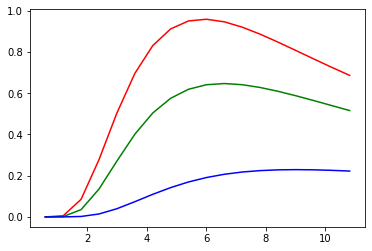

Edge loss curve, factor= tf.Tensor(
[0.99991083 0.96432877 0.94882125 0.9318783  0.90773296 0.894757
 0.89347285 0.8978741  0.90807956 0.9275631  0.9662322  1.0281247
 1.0827937  1.1077998  1.1049197  1.1007452  1.0976572  1.0952373 ], shape=(18,), dtype=float32)
Loss vertical orientation factors: tf.Tensor([0.54132485 0.54132485 0.54132485], shape=(3,), dtype=float32)
Loss equivalent vertical orientation factors: tf.Tensor([-0.43275213 -0.43275213 -0.43275213], shape=(3,), dtype=float32)


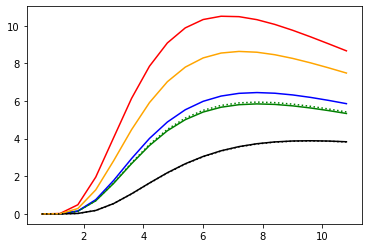

ELOSF: <tf.Variable 'elosf:0' shape=() dtype=float32, numpy=0.54132485>
Pair beta: tf.Tensor(0.01799999, shape=(), dtype=float32) pair_gapgain_w tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Diffs, pair, total:


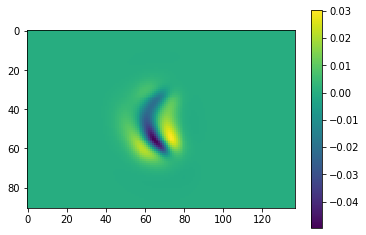

Penalties:


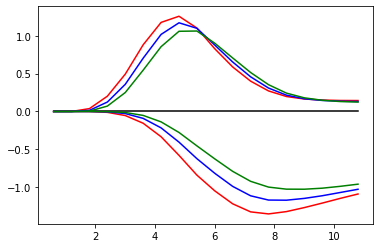

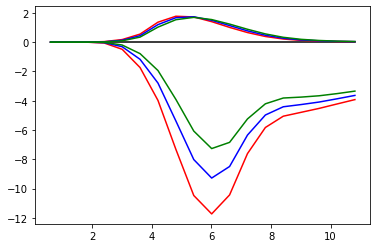

Legibility scores: [-72.62615 -57.42299 -44.91886] cost: tf.Tensor(21.08943, shape=(), dtype=float32)
20/20 [==============================] - 5s 229ms/step - loss: 21.6181 - val_loss: 20.9774
Epoch 11/1000
20/20 [==============================] - 3s 126ms/step - loss: 19.2845
Epoch 12/1000
20/20 [==============================] - 2s 115ms/step - loss: 15.4455
Epoch 13/1000
20/20 [==============================] - 2s 116ms/step - loss: 11.0467
Epoch 14/1000
20/20 [==============================] - 2s 117ms/step - loss: 5.8530
Epoch 15/1000
20/20 [==============================] - 2s 118ms/step - loss: 2.9903
Epoch 16/1000
20/20 [==============================] - 2s 117ms/step - loss: 0.7075
Epoch 17/1000
20/20 [==============================] - 2s 116ms/step - loss: 1.5775
Epoch 18/1000
20/20 [==============================] - 2s 117ms/step - loss: 2.0665
Epoch 19/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.9419
Epoch 20/1000
19/20 [===========================

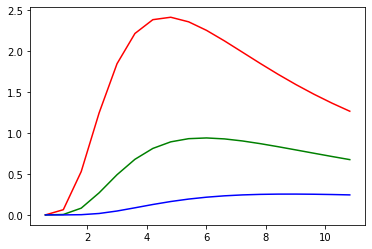

Edge loss curve, factor= tf.Tensor(
[0.999857   0.95090485 0.9281806  0.90664697 0.87740207 0.8667371
 0.8750438  0.8925818  0.92011714 0.96157336 1.0208154  1.0870707
 1.1322354  1.1472794  1.1379625  1.1299007  1.124428   1.1204525 ], shape=(18,), dtype=float32)
Loss vertical orientation factors: tf.Tensor([0.54132485 0.54132485 0.54132485], shape=(3,), dtype=float32)
Loss equivalent vertical orientation factors: tf.Tensor([-0.43275213 -0.43275213 -0.43275213], shape=(3,), dtype=float32)


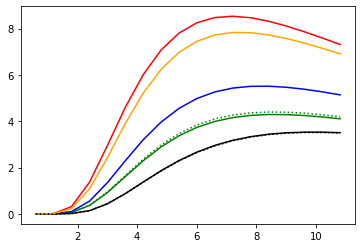

ELOSF: <tf.Variable 'elosf:0' shape=() dtype=float32, numpy=0.54132485>
Pair beta: tf.Tensor(0.01799999, shape=(), dtype=float32) pair_gapgain_w tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Diffs, pair, total:


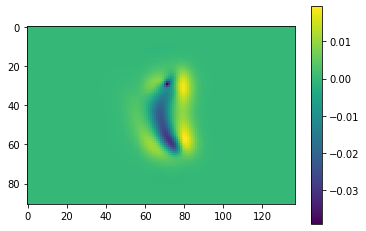

Penalties:


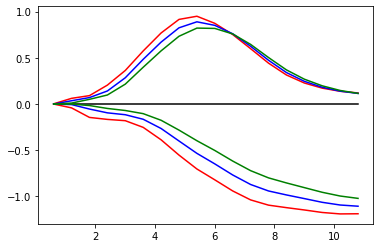

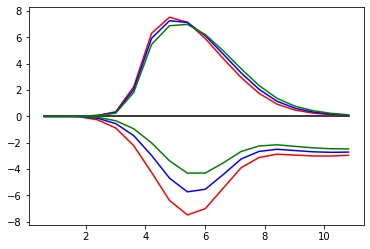

Legibility scores: [-15.177071   -3.2095528   6.111    ] cost: tf.Tensor(0.11857843, shape=(), dtype=float32)
20/20 [==============================] - 4s 213ms/step - loss: 1.7352 - val_loss: 0.6682
Epoch 21/1000
20/20 [==============================] - 3s 127ms/step - loss: 1.4081
Epoch 22/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.7066
Epoch 23/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.3564
Epoch 24/1000
20/20 [==============================] - 2s 116ms/step - loss: 1.8600
Epoch 25/1000
20/20 [==============================] - 2s 116ms/step - loss: 2.4990
Epoch 26/1000
20/20 [==============================] - 2s 117ms/step - loss: 1.8926
Epoch 27/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.3440
Epoch 28/1000
20/20 [==============================] - 2s 114ms/step - loss: 2.2941
Epoch 29/1000
20/20 [==============================] - 2s 116ms/step - loss: 2.0362
Epoch 30/1000
19/20 [========================

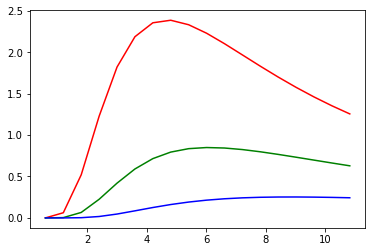

Edge loss curve, factor= tf.Tensor(
[0.9998512  0.9467948  0.9206422  0.89759713 0.8674546  0.8595612
 0.8724596  0.89345664 0.9229929  0.96500534 1.0235535  1.0882418
 1.1315241  1.1451867  1.1352509  1.1270686  1.1217937  1.1182126 ], shape=(18,), dtype=float32)
Loss vertical orientation factors: tf.Tensor([0.54132485 0.54132485 0.54132485], shape=(3,), dtype=float32)
Loss equivalent vertical orientation factors: tf.Tensor([-0.43275213 -0.43275213 -0.43275213], shape=(3,), dtype=float32)


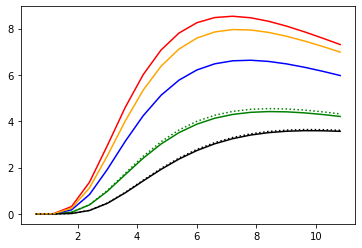

ELOSF: <tf.Variable 'elosf:0' shape=() dtype=float32, numpy=0.54132485>
Pair beta: tf.Tensor(0.01799999, shape=(), dtype=float32) pair_gapgain_w tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Diffs, pair, total:


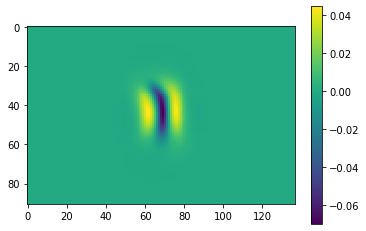

Penalties:


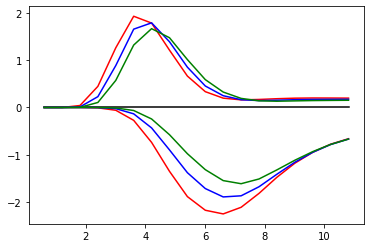

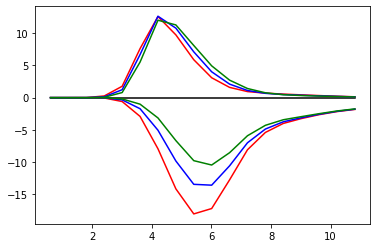

Legibility scores: [-55.306038 -32.005547 -13.851791] cost: tf.Tensor(3.1082616, shape=(), dtype=float32)
20/20 [==============================] - 4s 209ms/step - loss: 1.8657 - val_loss: 1.4435
Epoch 31/1000
20/20 [==============================] - 3s 127ms/step - loss: 2.4647
Epoch 32/1000
20/20 [==============================] - 2s 114ms/step - loss: 1.5837
Epoch 33/1000
20/20 [==============================] - 2s 116ms/step - loss: 1.0905
Epoch 34/1000
20/20 [==============================] - 2s 115ms/step - loss: 3.2132
Epoch 35/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.7247
Epoch 36/1000
20/20 [==============================] - 2s 117ms/step - loss: 0.8004
Epoch 37/1000
20/20 [==============================] - 2s 117ms/step - loss: 1.4429
Epoch 38/1000
20/20 [==============================] - 2s 116ms/step - loss: 1.3799
Epoch 39/1000
20/20 [==============================] - 2s 116ms/step - loss: 1.1576
Epoch 40/1000
19/20 [===========================>

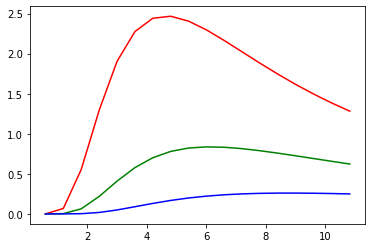

Edge loss curve, factor= tf.Tensor(
[0.99984753 0.9443816  0.91640997 0.8933027  0.86353606 0.85920364
 0.876276   0.8994858  0.9295913  0.97104216 1.0285442  1.0919768
 1.1340585  1.1469275  1.1367373  1.1286658  1.123696   1.1204851 ], shape=(18,), dtype=float32)
Loss vertical orientation factors: tf.Tensor([0.54132485 0.54132485 0.54132485], shape=(3,), dtype=float32)
Loss equivalent vertical orientation factors: tf.Tensor([-0.43275213 -0.43275213 -0.43275213], shape=(3,), dtype=float32)


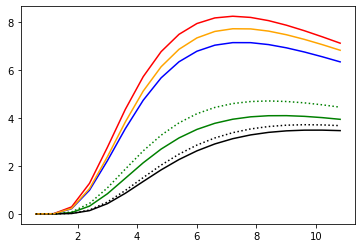

ELOSF: <tf.Variable 'elosf:0' shape=() dtype=float32, numpy=0.54132485>
Pair beta: tf.Tensor(0.01799999, shape=(), dtype=float32) pair_gapgain_w tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Diffs, pair, total:


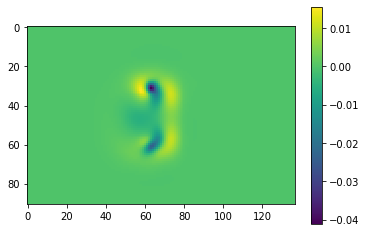

Penalties:


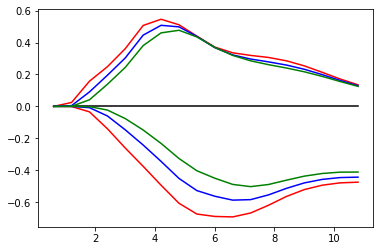

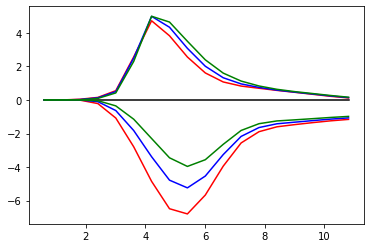

Legibility scores: [-22.7755    -11.37793    -2.4064045] cost: tf.Tensor(1.6083994, shape=(), dtype=float32)
20/20 [==============================] - 4s 211ms/step - loss: 1.7096 - val_loss: 0.8424
Epoch 41/1000
20/20 [==============================] - 3s 127ms/step - loss: 0.9007
Epoch 42/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.4487
Epoch 43/1000
20/20 [==============================] - 2s 116ms/step - loss: 1.5068
Epoch 44/1000
20/20 [==============================] - 2s 117ms/step - loss: 1.9126
Epoch 45/1000
20/20 [==============================] - 2s 117ms/step - loss: 1.3840
Epoch 46/1000
20/20 [==============================] - 2s 118ms/step - loss: 1.7222
Epoch 47/1000
20/20 [==============================] - 2s 118ms/step - loss: 1.4299
Epoch 48/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.6077
Epoch 49/1000
20/20 [==============================] - 2s 118ms/step - loss: 1.7013
Epoch 50/1000
19/20 [=========================

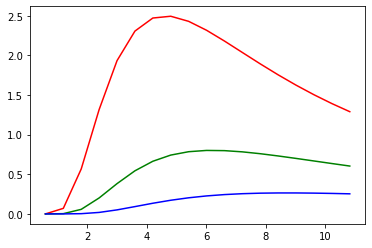

Edge loss curve, factor= tf.Tensor(
[0.9998394  0.93854874 0.9060663  0.8829235  0.8550991  0.8553514
 0.8766939  0.9023849  0.93358    0.9752928  1.0326147  1.0954471
 1.1363999  1.1479571  1.136734   1.1280631  1.1228538  1.1196662 ], shape=(18,), dtype=float32)
Loss vertical orientation factors: tf.Tensor([0.54132485 0.54132485 0.54132485], shape=(3,), dtype=float32)
Loss equivalent vertical orientation factors: tf.Tensor([-0.43275213 -0.43275213 -0.43275213], shape=(3,), dtype=float32)


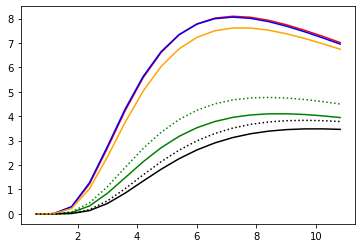

ELOSF: <tf.Variable 'elosf:0' shape=() dtype=float32, numpy=0.54132485>
Pair beta: tf.Tensor(0.01799999, shape=(), dtype=float32) pair_gapgain_w tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Diffs, pair, total:


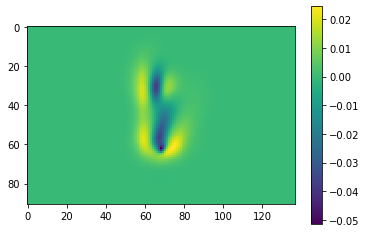

Penalties:


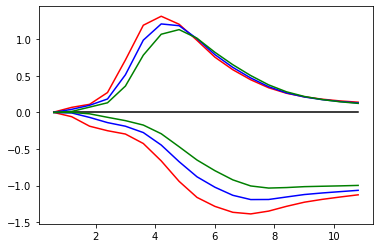

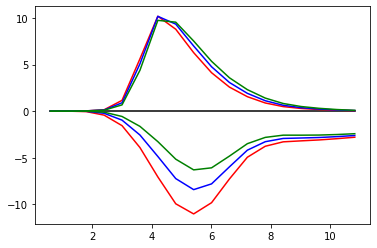

Legibility scores: [-32.64455    -14.601772    -0.39374542] cost: tf.Tensor(1.056194, shape=(), dtype=float32)
20/20 [==============================] - 4s 222ms/step - loss: 1.6394 - val_loss: 2.0312
Epoch 51/1000
20/20 [==============================] - 3s 127ms/step - loss: 1.2350
Epoch 52/1000
20/20 [==============================] - 2s 119ms/step - loss: 1.2569
Epoch 53/1000
20/20 [==============================] - 2s 116ms/step - loss: 2.0966
Epoch 54/1000
20/20 [==============================] - 2s 117ms/step - loss: 1.3950
Epoch 55/1000
20/20 [==============================] - 2s 116ms/step - loss: 2.4072
Epoch 56/1000
20/20 [==============================] - 2s 116ms/step - loss: 1.3144
Epoch 57/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.2486
Epoch 58/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.0100
Epoch 59/1000
20/20 [==============================] - 2s 114ms/step - loss: 2.0579
Epoch 60/1000
19/20 [=======================

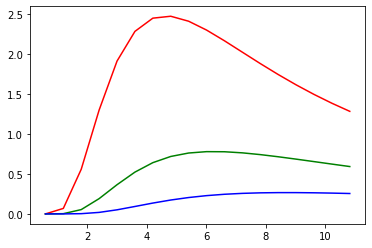

Edge loss curve, factor= tf.Tensor(
[0.9998379  0.9352415  0.89899963 0.87564635 0.8509615  0.85669744
 0.8810953  0.9070163  0.9371784  0.9770665  1.0323045  1.0929325
 1.1318257  1.1421055  1.1306443  1.1223847  1.1180646  1.116051  ], shape=(18,), dtype=float32)
Loss vertical orientation factors: tf.Tensor([0.54132485 0.54132485 0.54132485], shape=(3,), dtype=float32)
Loss equivalent vertical orientation factors: tf.Tensor([-0.43275213 -0.43275213 -0.43275213], shape=(3,), dtype=float32)


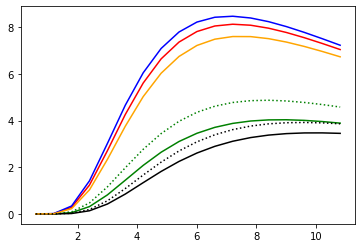

ELOSF: <tf.Variable 'elosf:0' shape=() dtype=float32, numpy=0.54132485>
Pair beta: tf.Tensor(0.01799999, shape=(), dtype=float32) pair_gapgain_w tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Diffs, pair, total:


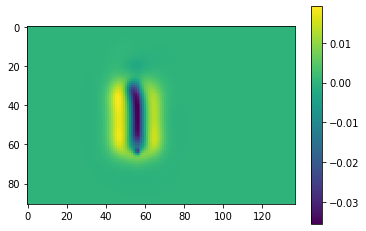

Penalties:


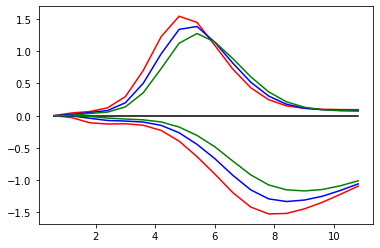

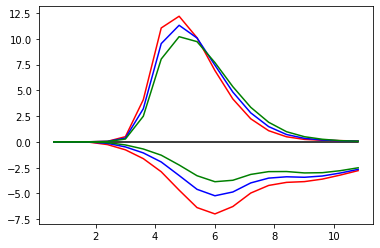

Legibility scores: [-2.8994064  7.696495  15.388729 ] cost: tf.Tensor(0.5276066, shape=(), dtype=float32)
20/20 [==============================] - 4s 214ms/step - loss: 1.8976 - val_loss: 3.1791
Epoch 61/1000
20/20 [==============================] - 3s 125ms/step - loss: 1.5949
Epoch 62/1000
20/20 [==============================] - 2s 116ms/step - loss: 1.0851
Epoch 63/1000
20/20 [==============================] - 2s 117ms/step - loss: 2.5598
Epoch 64/1000
20/20 [==============================] - 2s 116ms/step - loss: 1.6285
Epoch 65/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.0529
Epoch 66/1000
20/20 [==============================] - 2s 114ms/step - loss: 1.1814
Epoch 67/1000
20/20 [==============================] - 2s 117ms/step - loss: 1.5019
Epoch 68/1000
20/20 [==============================] - 2s 116ms/step - loss: 2.1586
Epoch 69/1000
20/20 [==============================] - 2s 117ms/step - loss: 1.5608
Epoch 70/1000
19/20 [===========================>

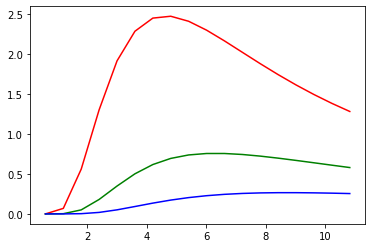

Edge loss curve, factor= tf.Tensor(
[0.9998307  0.930298   0.8904709  0.8669791  0.8434523  0.8539432
 0.8826904  0.91046154 0.94101906 0.98045146 1.034925   1.0946873
 1.1326605  1.1421895  1.1303974  1.1221983  1.1182314  1.1167359 ], shape=(18,), dtype=float32)
Loss vertical orientation factors: tf.Tensor([0.54132485 0.54132485 0.54132485], shape=(3,), dtype=float32)
Loss equivalent vertical orientation factors: tf.Tensor([-0.43275213 -0.43275213 -0.43275213], shape=(3,), dtype=float32)


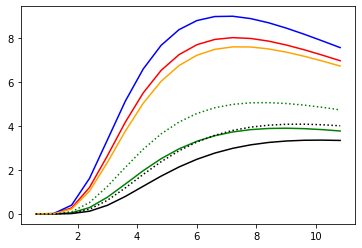

ELOSF: <tf.Variable 'elosf:0' shape=() dtype=float32, numpy=0.54132485>
Pair beta: tf.Tensor(0.01799999, shape=(), dtype=float32) pair_gapgain_w tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Diffs, pair, total:


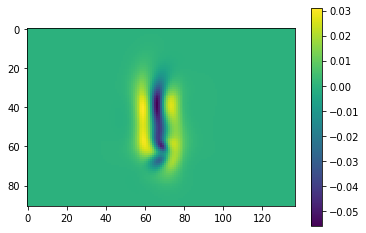

Penalties:


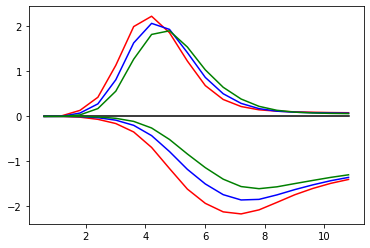

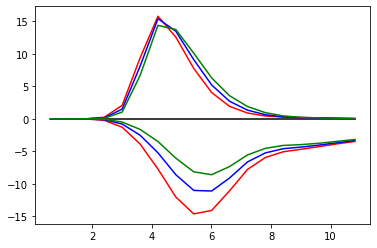

Legibility scores: [-43.808746 -21.643066  -4.377495] cost: tf.Tensor(1.57136, shape=(), dtype=float32)
20/20 [==============================] - 4s 207ms/step - loss: 1.3486 - val_loss: 4.6014
Epoch 71/1000
20/20 [==============================] - 3s 127ms/step - loss: 1.9721
Epoch 72/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.0064
Epoch 73/1000
20/20 [==============================] - 2s 116ms/step - loss: 1.5335
Epoch 74/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.1626
Epoch 75/1000
20/20 [==============================] - 2s 115ms/step - loss: 3.8712
Epoch 76/1000
20/20 [==============================] - 2s 120ms/step - loss: 2.5755
Epoch 77/1000
20/20 [==============================] - 2s 117ms/step - loss: 1.3493
Epoch 78/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.3393
Epoch 79/1000
20/20 [==============================] - 2s 118ms/step - loss: 1.8381
Epoch 80/1000
19/20 [===========================>..

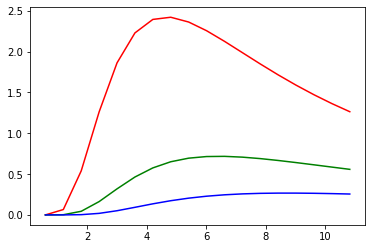

Edge loss curve, factor= tf.Tensor(
[0.99981904 0.9232769  0.8800809  0.856207   0.8318154  0.846871
 0.880356   0.9102003  0.9414083  0.9807718  1.0348709  1.0941064
 1.1313288  1.1401538  1.1280047  1.1197921  1.1161094  1.1150506 ], shape=(18,), dtype=float32)
Loss vertical orientation factors: tf.Tensor([0.54132485 0.54132485 0.54132485], shape=(3,), dtype=float32)
Loss equivalent vertical orientation factors: tf.Tensor([-0.43275213 -0.43275213 -0.43275213], shape=(3,), dtype=float32)


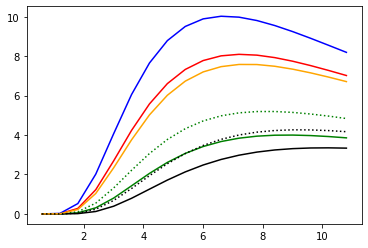

ELOSF: <tf.Variable 'elosf:0' shape=() dtype=float32, numpy=0.54132485>
Pair beta: tf.Tensor(0.01799999, shape=(), dtype=float32) pair_gapgain_w tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Diffs, pair, total:


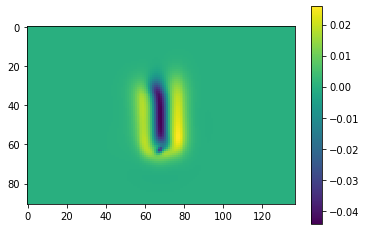

Penalties:


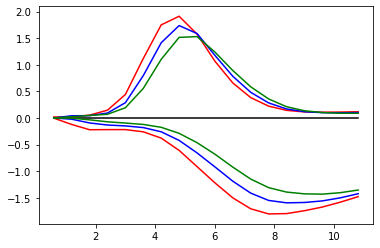

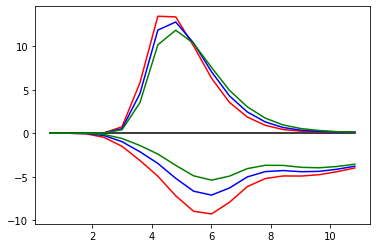

Legibility scores: [-20.657318   -5.8347816   5.4742775] cost: tf.Tensor(0.2661928, shape=(), dtype=float32)
20/20 [==============================] - 4s 223ms/step - loss: 1.3069 - val_loss: 3.0009
Epoch 81/1000
20/20 [==============================] - 3s 127ms/step - loss: 1.7621
Epoch 82/1000
20/20 [==============================] - 2s 116ms/step - loss: 1.3362
Epoch 83/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.8037
Epoch 84/1000
20/20 [==============================] - 2s 116ms/step - loss: 2.6905
Epoch 85/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.3059
Epoch 86/1000
20/20 [==============================] - 2s 117ms/step - loss: 1.6315
Epoch 87/1000
20/20 [==============================] - 2s 116ms/step - loss: 1.2713
Epoch 88/1000
20/20 [==============================] - 2s 118ms/step - loss: 1.9870
Epoch 89/1000
20/20 [==============================] - 2s 118ms/step - loss: 1.2259
Epoch 90/1000
19/20 [=========================

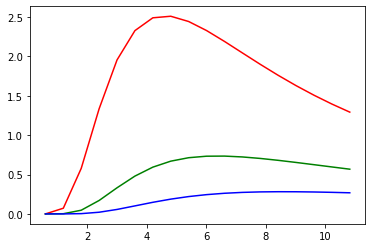

Edge loss curve, factor= tf.Tensor(
[0.99979615 0.91280365 0.86821985 0.84589446 0.8240421  0.84640837
 0.8848885  0.916442   0.9474306  0.9858632  1.0387182  1.0966781
 1.1325818  1.1403426  1.1276978  1.1194642  1.1161829  1.1158143 ], shape=(18,), dtype=float32)
Loss vertical orientation factors: tf.Tensor([0.54132485 0.54132485 0.54132485], shape=(3,), dtype=float32)
Loss equivalent vertical orientation factors: tf.Tensor([-0.43275213 -0.43275213 -0.43275213], shape=(3,), dtype=float32)


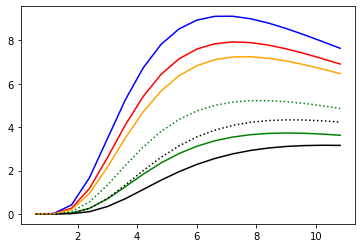

ELOSF: <tf.Variable 'elosf:0' shape=() dtype=float32, numpy=0.54132485>
Pair beta: tf.Tensor(0.01799999, shape=(), dtype=float32) pair_gapgain_w tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Diffs, pair, total:


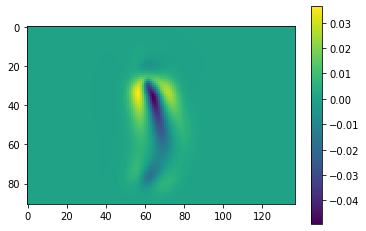

Penalties:


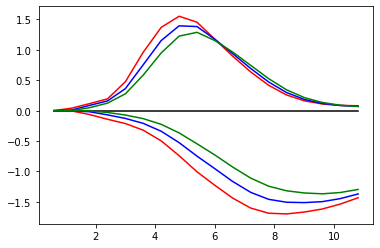

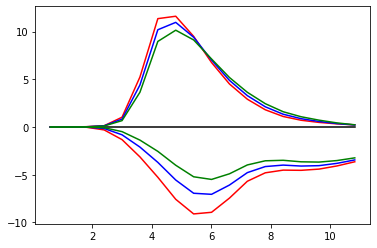

Legibility scores: [-17.03645   -4.083721   5.972477] cost: tf.Tensor(0.16490905, shape=(), dtype=float32)
20/20 [==============================] - 4s 212ms/step - loss: 1.0728 - val_loss: 3.6091
Epoch 91/1000
20/20 [==============================] - 3s 126ms/step - loss: 1.0694
Epoch 92/1000
20/20 [==============================] - 2s 116ms/step - loss: 3.5070
Epoch 93/1000
20/20 [==============================] - 2s 116ms/step - loss: 1.3540
Epoch 94/1000
20/20 [==============================] - 2s 117ms/step - loss: 2.0465
Epoch 95/1000
20/20 [==============================] - 2s 116ms/step - loss: 2.5199
Epoch 96/1000
20/20 [==============================] - 2s 114ms/step - loss: 1.8846
Epoch 97/1000
20/20 [==============================] - 2s 116ms/step - loss: 0.8079
Epoch 98/1000
20/20 [==============================] - 2s 116ms/step - loss: 1.1901
Epoch 99/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.4963
Epoch 100/1000
19/20 [==========================

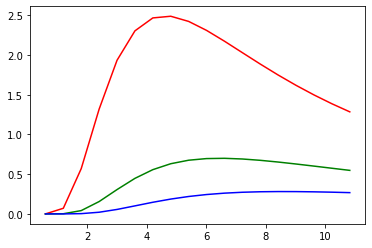

Edge loss curve, factor= tf.Tensor(
[0.9997674  0.8942792  0.8476005  0.83047086 0.8136261  0.84208447
 0.88565755 0.91932017 0.9506369  0.98848295 1.0405774  1.097797
 1.1330051  1.1401995  1.1273465  1.1192642  1.116364   1.1164421 ], shape=(18,), dtype=float32)
Loss vertical orientation factors: tf.Tensor([0.54132485 0.54132485 0.54132485], shape=(3,), dtype=float32)
Loss equivalent vertical orientation factors: tf.Tensor([-0.43275213 -0.43275213 -0.43275213], shape=(3,), dtype=float32)


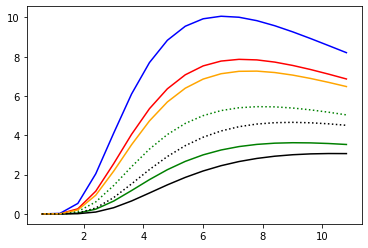

ELOSF: <tf.Variable 'elosf:0' shape=() dtype=float32, numpy=0.54132485>
Pair beta: tf.Tensor(0.01799999, shape=(), dtype=float32) pair_gapgain_w tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Diffs, pair, total:


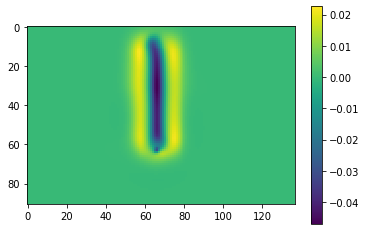

Penalties:


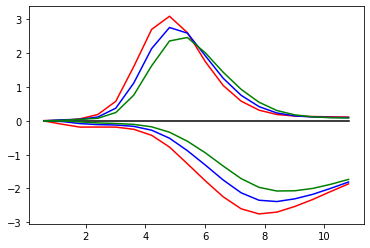

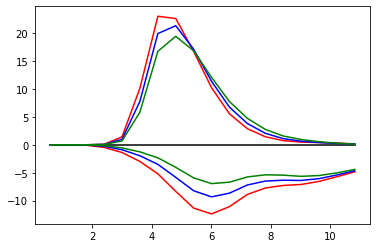

Legibility scores: [-4.960945 12.719231 25.584076] cost: tf.Tensor(0.5175455, shape=(), dtype=float32)
20/20 [==============================] - 4s 211ms/step - loss: 1.5831 - val_loss: 1.7884
Epoch 101/1000
20/20 [==============================] - 3s 125ms/step - loss: 1.8050
Epoch 102/1000
20/20 [==============================] - 2s 116ms/step - loss: 0.7420
Epoch 103/1000
20/20 [==============================] - 2s 115ms/step - loss: 1.5690
Epoch 104/1000
20/20 [==============================] - 2s 118ms/step - loss: 1.3732
Epoch 105/1000
20/20 [==============================] - 2s 116ms/step - loss: 1.3212
Epoch 106/1000
20/20 [==============================] - 2s 117ms/step - loss: 1.8124
Epoch 107/1000
20/20 [==============================] - 2s 117ms/step - loss: 1.0777
Epoch 108/1000
20/20 [==============================] - 2s 117ms/step - loss: 0.9839
Epoch 109/1000
20/20 [==============================] - 2s 117ms/step - loss: 2.1678
Epoch 110/1000
19/20 [=====================

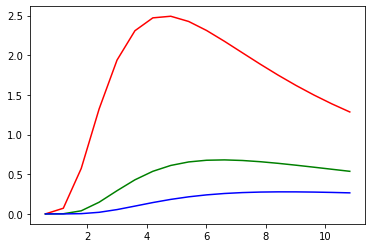

Edge loss curve, factor= tf.Tensor(
[0.99974537 0.8744027  0.8216645  0.8070639  0.7995944  0.83660126
 0.88489646 0.9205071  0.952322   0.99003375 1.0417655  1.0985234
 1.1330476  1.1394922  1.1261369  1.1178969  1.1151537  1.1155967 ], shape=(18,), dtype=float32)
Loss vertical orientation factors: tf.Tensor([0.54132485 0.54132485 0.54132485], shape=(3,), dtype=float32)
Loss equivalent vertical orientation factors: tf.Tensor([-0.43275213 -0.43275213 -0.43275213], shape=(3,), dtype=float32)


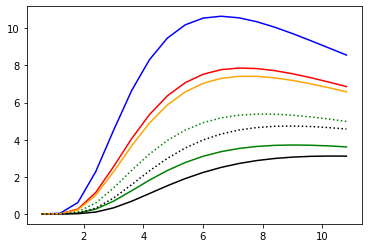

ELOSF: <tf.Variable 'elosf:0' shape=() dtype=float32, numpy=0.54132485>
Pair beta: tf.Tensor(0.01799999, shape=(), dtype=float32) pair_gapgain_w tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)
Diffs, pair, total:


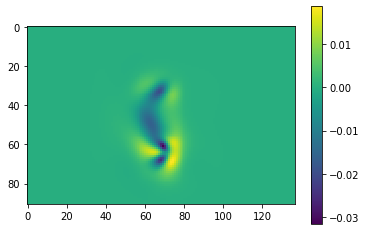

Penalties:


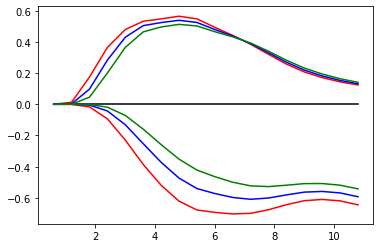

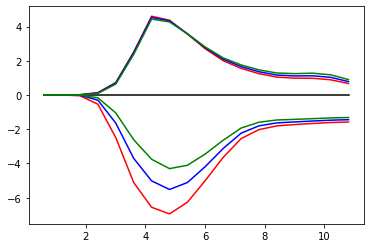

Legibility scores: [-21.583078  -11.499348   -3.0875015] cost: tf.Tensor(1.868804, shape=(), dtype=float32)
20/20 [==============================] - 4s 212ms/step - loss: 1.2334 - val_loss: 1.9689
Epoch 111/1000
18/20 [==========================>...] - ETA: 0s - loss: 1.7642

KeyboardInterrupt: ignored

In [0]:
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()

ig = InputGenerator(batch_size)
if True:
    model = get_model()
    model.compile(loss=compute_loss,
                optimizer=tf.keras.optimizers.Adam(0.0010, amsgrad=True))
    #model.summary()
    history = model.fit_generator(ig,
                                callbacks=[MonitorProgressCallback(ig)],
                                validation_data=ig,
                                validation_steps=1,
                                validation_freq=10,
                                epochs=1000,
                                steps_per_epoch=20, use_multiprocessing=False)
ig.kill()
tf.compat.v1.reset_default_graph()
tf.keras.backend.clear_session()

## Use trained model to predict letter distances

In [0]:
distances = [-3, 0, 2, 4, 6, 8, 10, 12, 15, 20]
distances = [0, 8, 16]
predicted_kerning_dict = {}
glyph_data = {}
for glyph_char in tqdm(glyph_char_list):
    glyph_data[glyph_char] = get_glyph_data_with_filtered_as_dict(glyph_char)

for gl in glyph_char_list:
    for gr in glyph_char_list:
        with tf.device('/CPU:0'):
            tight_dist = 0
            mid_dist = 8
            loose_dist = 16
            dist_deltas = np.array([mid_dist - tight_dist, loose_dist - mid_dist]) 
            updates = 0
            while abs(loose_dist - tight_dist) >= 3 and updates < 10:
                cpd = shift_and_overlay_pair_data(glyph_data[gl], glyph_data[gr], [tight_dist, mid_dist, loose_dist])
                if False:
                    print("dist 0")
                    plt.imshow(cpd['pair_images'][:, :, 0])
                    plt.show()
                    plt.imshow(cpd['pair_images'][:, :, 1])
                    plt.show()
                    plt.imshow(cpd['pair_images'][:, :, 2])
                    plt.show()
                    print(cpd['pair_images'][None, :, :, :].shape) 
                inputs = [
                    cpd['shifted_gd1_d1_filtered_images'][None, :, :, :, :, :],
                    cpd['shifted_gd2_d1_filtered_images'][None, :, :, :, :, :],
                    cpd['sample_distances'][None, :],
                    cpd['pair_images'][None, :, :, :],
                    np.array(cpd['zero_index'])[None],
                ]   
    
                d = model.predict(inputs)
    
                constrained_slopes = (d[0, 1:] - d[0, 0:-1]) / dist_deltas # right now delta-x is equal spacing
                predicted_zeros = np.array([tight_dist, mid_dist]) - d[:, 0:-1] / constrained_slopes
        
                if d[0, 0] > 0: # if even the first is above zero:
                    loose_dist = tight_dist
                    mid_dist = predicted_zeros[0, 0]
                    tight_dist = mid_dist - (loose_dist - mid_dist)
                elif d[0, 0] < 0 and d[0, 1] >= 0:
                    loose_dist = mid_dist
                    mid_dist = predicted_zeros[0, 0]
                elif d[0, 0] < 0 and d[0, 1] < 0 and d[0, 2] > 0:
                    tight_dist = mid_dist
                    mid_dist = predicted_zeros[0, 1]
                elif d[0, 0] < 0 and d[0, 1] < 0 and d[0, 2] < 0:
                    tight_dist = loose_dist
                    mid_dist = predicted_zeros[0, 1]
                    loose_dist = mid_dist + (mid_dist - tight_dist)
                else:
                    print("nothing happened")

                dist_deltas = np.array([mid_dist - tight_dist, loose_dist - mid_dist]) 

                print("New best distance:", gl, gr, mid_dist, [tight_dist, mid_dist, loose_dist], d[0, :])
                updates += 1

            predicted_kerning_dict[gl, gr] = int(mid_dist) - f.minimum_ink_distance(gl, gr)
            print("Predicted dist,", gl, gr, ":", predicted_kerning_dict[gl, gr], "(original distance:", f.pair_distance(gl, gr), ")")
            #print("Predicted zero was:", , "mindist:", f.minimum_ink_distance(gl, gr))


100%|██████████| 26/26 [00:00<00:00, 90.42it/s]


New best distance: a a 7.18743446293532 [0, 7.18743446293532, 8] [-142.24136    16.080898   25.499956]
New best distance: a a 6.774854225304283 [0, 6.774854225304283, 7.18743446293532] [-142.24136     8.662331   16.080898]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: divide by zero encountered in true_divide


New best distance: a a 6.3859573274465 [0, 6.3859573274465, 6.774854225304283] [-142.24136     8.662331    8.662331]
New best distance: a a 6.019384274816044 [0, 6.019384274816044, 6.3859573274465] [-142.24136     8.662331    8.662331]
New best distance: a a 5.673853611920527 [0, 5.673853611920527, 6.019384274816044] [-142.24136     8.662331    8.662331]
New best distance: a a 5.893741720631939 [5.673853611920527, 5.893741720631939, 6.019384274816044] [-142.24136   -15.160019    8.662331]
Predicted dist, a a : 3 (original distance: 3 )
New best distance: a b 7.185466914335129 [0, 7.185466914335129, 8] [-191.34004    21.689999   32.350586]
New best distance: a b 6.723236719464781 [0, 6.723236719464781, 7.185466914335129] [-191.34004    13.15485    21.689999]
New best distance: a b 6.290741092382037 [0, 6.290741092382037, 6.723236719464781] [-191.34004   13.15485   13.15485]
New best distance: a b 5.886067253412769 [0, 5.886067253412769, 6.290741092382037] [-191.34004   13.15485   13.154

In [0]:
print("Font scaling factor is", f.scale_factor)

Font scaling factor is 0.0895150115473441


In [0]:
ufo = defcon.Font()
extractor.extractUFO(filename, ufo, doKerning=False)

print("Adding kerning data ...", gl)
import string
for gl in string.ascii_lowercase:
    ufo.layers.defaultLayer[gl].leftMargin = 0 #lsb
    ufo.layers.defaultLayer[gl].rightMargin = 0 #rsb
    for gr in string.ascii_lowercase:
        ufo.kerning[(gl, gr)] = predicted_kerning_dict[(gl, gr)] / f.scale_factor
print("Compiling to OTF ...")
otf = compileOTF(ufo)
otf.save('example-output.otf')
print("Compilation done.")


Adding kerning data ... f
Compiling to OTF ...
Compilation done.
